<a href="https://colab.research.google.com/github/GarettGazay/ai_projects/blob/master/RBSeq2Seq_Train_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Understand the predictions better, what are are these vectors it returns? A: They are the model's attempt at becoming the target.

1. Verify the input and target data are in fact the same data with the input shuffled and the target in the correct order.

2. Use the padding function to pad each batch to the correct dims (125,12)

3. Take 2 random days out of the data and convert it into a validation set, then try to implement early stopping.

4. Mini-batch train so the model can learn more and perhaps become better at predictions.

5. If training on more data does not improve the model, try looking at the data to see if there should be more, different, or less.

### Prediction

- Correlate the predicted values with the input dataframe with headers, try to place the input data in order in a df with the predictions.

- Find the most closely related (prediction, rides) values and arrange them according to the prediction order.

- Walk through by creating a loop where we check for highest similarity between each ride in input_data and the predictions. Then order the rides in line with the predictions that way so it finds the most similar ride in inputs starting at the top of the predictions list.

- Getting some correct results, but many are still out of order.

- Check the accuracy of top 5 similarities

- It could be that the predictions are accurate to the the targets, but with cos_similiarity, but they are still not accurate to predict on the input data.

- May need to continue training the model to get better predictions.

- May need to train on more data to learn the human decision making rhythms and nuances to find the correct orderings.

- Thinking about this in terms of seq2seq, the model might not be very good at generalizing order of a single sequence having only trained on a single sequence. It may be that by training on many sequences, it will learn the nuance that guides it toward robust predictions.

In [59]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import time

In [60]:
rides = pd.read_csv('/content/ordering_dataset.csv')

In [61]:
rides = rides.drop(['Unnamed: 0',
                    'order',
                    'rider.first_name',
                    'rider.last_name',
                    'pickup.event_location.address1',
                    'dropoff.event_location.address1',
                    'run_name_id',
                    'pickup_time',
                    ], axis=1)

In [62]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_month,pickup_day,pickup_hour,pickup_minute
0,0.857143,0.012314,0.10,0.169343,0.583333,-0.990825,0.848788,0.837838,-0.990424,0.848616,1.0,1.0,0.173913,0.517241
1,0.857143,0.006394,0.10,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
2,0.857143,0.003826,0.10,0.167883,0.833333,-0.990800,0.846893,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
3,0.285714,0.023389,0.05,0.202920,0.791667,-0.990521,0.846884,0.675676,-0.989395,0.845235,1.0,1.0,0.304348,0.206897
4,0.285714,0.018819,0.05,0.084672,0.750000,-0.989852,0.847646,0.729730,-0.989807,0.845745,1.0,1.0,0.347826,0.517241


In [63]:
rides = rides.astype('float32')

In [64]:
# Count the number of NaN values in each column
nan_counts = rides.isna().sum()

# Display the count of NaN values for each column
print(nan_counts)

space_type                          0
billable_distance                   1
run_name                            0
rider.mediroutes_rider_id           0
pickup.event_location.zip           0
pickup.event_location.longitude     1
pickup.event_location.latitude      1
dropoff.event_location.zip          0
dropoff.event_location.longitude    1
dropoff.event_location.latitude     1
pickup_month                        1
pickup_day                          1
pickup_hour                         1
pickup_minute                       1
dtype: int64


In [65]:
rides.fillna(0, inplace=True)

In [66]:
rides.dtypes

space_type                          float32
billable_distance                   float32
run_name                            float32
rider.mediroutes_rider_id           float32
pickup.event_location.zip           float32
pickup.event_location.longitude     float32
pickup.event_location.latitude      float32
dropoff.event_location.zip          float32
dropoff.event_location.longitude    float32
dropoff.event_location.latitude     float32
pickup_month                        float32
pickup_day                          float32
pickup_hour                         float32
pickup_minute                       float32
dtype: object

In [67]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_month,pickup_day,pickup_hour,pickup_minute
0,0.857143,0.012314,0.10,0.169343,0.583333,-0.990825,0.848788,0.837838,-0.990424,0.848616,1.0,1.0,0.173913,0.517241
1,0.857143,0.006394,0.10,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
2,0.857143,0.003826,0.10,0.167883,0.833333,-0.990800,0.846893,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
3,0.285714,0.023389,0.05,0.202920,0.791667,-0.990521,0.846884,0.675676,-0.989395,0.845235,1.0,1.0,0.304348,0.206897
4,0.285714,0.018819,0.05,0.084672,0.750000,-0.989852,0.847646,0.729730,-0.989807,0.845745,1.0,1.0,0.347826,0.517241


In [68]:
counts = rides.groupby(['pickup_month', 'pickup_day']).size().reset_index(name='counts')
counts['counts'].mean()

99.41875

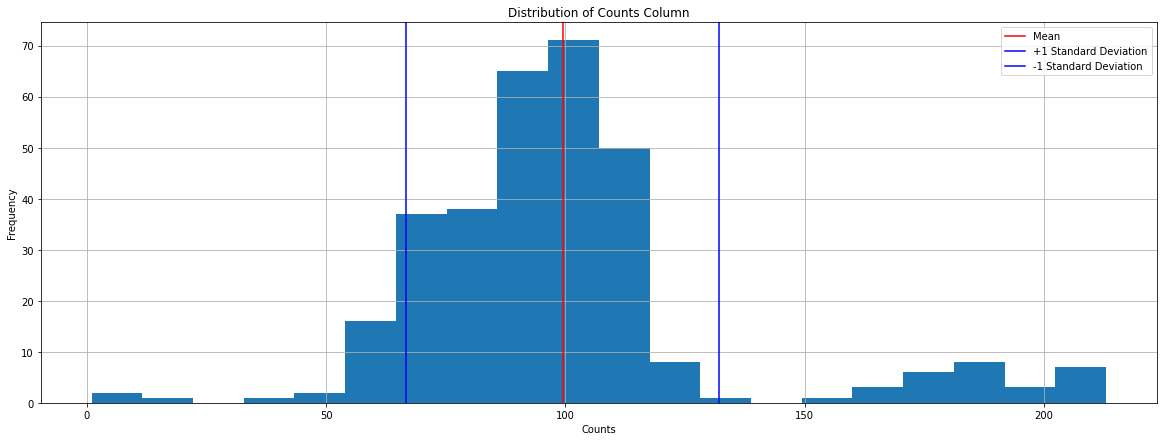

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))

import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean and standard deviation of the counts column
mean = counts['counts'].mean()
std = counts['counts'].std()

# Plot the histogram of the counts column
counts['counts'].hist(bins=20)

# Add vertical lines to indicate mean and standard deviation
plt.axvline(mean, color='red', label='Mean')
plt.axvline(mean + std, color='blue', label='+1 Standard Deviation')
plt.axvline(mean - std, color='blue', label='-1 Standard Deviation')

# Add title and labels
plt.title('Distribution of Counts Column')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

In [70]:
rides['pickup_day'] = rides['pickup_day'].fillna(0).astype(int)
rides['pickup_month'] = rides['pickup_month'].fillna(0).astype(int)

rides['pickup_day'] = rides['pickup_day'].astype(str)
rides['pickup_month'] = rides['pickup_month'].astype(str)

rides['id'] = rides['pickup_month'] + rides['pickup_day']

rides = rides.drop(['pickup_month','pickup_day'], axis=1)

In [71]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_hour,pickup_minute,id
0,0.857143,0.012314,0.10,0.169343,0.583333,-0.990825,0.848788,0.837838,-0.990424,0.848616,0.173913,0.517241,11
1,0.857143,0.006394,0.10,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,0.217391,0.517241,11
2,0.857143,0.003826,0.10,0.167883,0.833333,-0.990800,0.846893,0.797297,-0.990674,0.847189,0.217391,0.517241,11
3,0.285714,0.023389,0.05,0.202920,0.791667,-0.990521,0.846884,0.675676,-0.989395,0.845235,0.304348,0.206897,11
4,0.285714,0.018819,0.05,0.084672,0.750000,-0.989852,0.847646,0.729730,-0.989807,0.845745,0.347826,0.517241,11


In [72]:
rides.shape

(31814, 13)

In [73]:
rides = rides.astype(str)

In [74]:
rides.values[0].astype('float32')

array([ 0.857143,  0.012314,  0.1     ,  0.169343,  0.583333, -0.990825,
        0.848788,  0.837838, -0.990424,  0.848616,  0.173913,  0.517241,
       11.      ], dtype=float32)

# DAY NUMBER WE ARE TRAINING - SET IT HERE FOR ALL BELOW CODE

In [75]:
day_of_rides = 0
sequence_len = 200

Put rides into buckets by date

In [76]:
# Group the rows by the 'id' column
grouped = rides.groupby('id')

# Create a list to store the grouped arrays
day_buckets = []

# Loop through each group
for name, group in grouped:
    # Convert the group to a numpy array
    group_array = group.values.astype(np.float32)
    
    # Append the group array to the list of grouped arrays
    day_buckets.append(group_array)

# Set the display format of the numpy arrays
np.set_printoptions(precision=6, suppress=True)

# Sort the list of grouped arrays by the first column of each array
day_buckets.sort(key=lambda x: x[0][1])


In [77]:
# Do this or when you shuffle below it will shuffle both for some fucking reason, and copy doesn't work.
day_buckets_y = [x.astype(str) for x in day_buckets[1:]]

In [78]:
day_buckets_y[0][0]

array(['0.2857143', '0.0032280714', '0.2', '0.13868614', '0.6805556',
       '-0.990954', '0.8473343', '0.7972973', '-0.99070346', '0.84737885',
       '0.17391305', '0.25862068', '913.0'], dtype='<U32')

In [79]:
def shuffle_np_array(np_array_list):
    for i in range(len(np_array_list)):
        np.random.shuffle(np_array_list[i])
    return np_array_list

day_buckets_X = shuffle_np_array(day_buckets)[1:] # create a shuffled version for X below

In [80]:
input = []
target = []
for array in day_buckets_X:
    new_array = np.delete(array, -1, axis=1)
    input.append(new_array.astype('float32'))

count = 0
for array in day_buckets_y:
    new_array = np.delete(array, -1, axis=1)
    target.append(new_array.astype('float32'))


# Load the model for the training loop

In [81]:
# Set early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [82]:
# Create a TensorBoard callback
import datetime

logdir = "/content/drive/MyDrive/tensorboard_logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [83]:
def pad_array(arr):

    padding = np.zeros((1, 12))
    while arr.shape[0] < sequence_len:
        arr = np.concatenate((arr, padding), axis=0)
    return arr

def create_validation_set():
  random_validation_set = np.random.randint(0, len(day_buckets_X))

  if not random_validation_set == day_of_rides:
    print('random_validation_set: ', random_validation_set)
    print('day_of_rides: ', day_of_rides)
    X_val = input[-1].astype('float32')
    X_val = pad_array(X_val)

    y_val = target[-1].astype('float32')
    y_val = pad_array(y_val)

    return X_val, y_val
  else:
    # Recursively call the function until it lands on a random day of rides that doesn't match the training tensor.
    create_validation_set()

In [88]:
len(input)

304

Start loop here

In [89]:
first_run = False

# TRAINING LOOP
for day_of_rides in range(200, 304): # num days to be trained
  print(f'Training {day_of_rides} of {len(input)}')
  model = keras.models.load_model('/content/drive/MyDrive/Colab_Models/RBSeq2Seq')

  # Pad the input
  input[day_of_rides] = pad_array(input[day_of_rides])
  target[day_of_rides] = pad_array(target[day_of_rides])

  # Truncate input to defined sequence length
  input[day_of_rides] = input[day_of_rides][:sequence_len]
  target[day_of_rides] = target[day_of_rides][:sequence_len]

  # Create Random Validation Set
  X_val, y_val = create_validation_set()

  # Create Input and Target Df's
  input_df = pd.DataFrame(input[day_of_rides], columns=[
  'input_space_type',
  'input_billable_distance',
  'input_run_name',
  'input_rider.mediroutes_rider_id',
  'input_pickup.event_location.zip',
  'input_pickup.event_location.longitude',
  'input_pickup.event_location.latitude',
  'input_dropoff.event_location.zip',
  'input_dropoff.event_location.longitude',
  'input_dropoff.event_location.latitude',
  'input_pickup_hour',
  'input_pickup_minute'
  ])

  target_df = pd.DataFrame(target[day_of_rides], columns=[
  'target_space_type',
  'target_billable_distance',
  'target_run_name',
  'target_rider.mediroutes_rider_id',
  'target_pickup.event_location.zip',
  'target_pickup.event_location.longitude',
  'target_pickup.event_location.latitude',
  'target_dropoff.event_location.zip',
  'target_dropoff.event_location.longitude',
  'target_dropoff.event_location.latitude',
  'target_pickup_hour',
  'target_pickup_minute'
  ])

  check = pd.concat([input_df, target_df], axis=1)

  # Define the input and output shape
  input_shape = (sequence_len, 12)
  output_shape = (sequence_len, 12)

  # Set the input and target to the day of rides iteration
  input_orig = input[day_of_rides]
  target_orig = target[day_of_rides]

  input_ = input_orig.reshape(1, *input_orig.shape)
  target_ = target_orig.reshape(1, *target_orig.shape)
  X_val = X_val.reshape(1, *X_val.shape)
  y_val = y_val.reshape(1, *y_val.shape)

  print(input_.shape)
  print(input_.shape)
  print(X_val.shape)
  print(y_val.shape)

  # DEFINE THE MODEL

  # Define the encoder
  encoder_inputs = keras.layers.Input(shape=input_shape)
  encoder = keras.layers.LSTM(64, return_state=True)
  encoder_outputs, state_h, state_c = encoder(encoder_inputs)
  encoder_states = [state_h, state_c]

  # Define the decoder
  decoder_inputs = keras.layers.Input(shape=(None, 12))
  decoder_lstm = keras.layers.LSTM(64, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

  # Add the attention mechanism
  attention = keras.layers.Attention()([decoder_outputs, encoder_outputs])
  decoder_outputs = keras.layers.Concatenate()([decoder_outputs, attention])

  decoder_dense = keras.layers.Dense(12, activation='linear')
  decoder_outputs = decoder_dense(decoder_outputs)

  # Define the model
  if first_run:
    model = keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')

  # Train the model
  history = model.fit([input_, target_], target_, epochs=400, batch_size=16, validation_data=([X_val, y_val], y_val), callbacks=[early_stopping, tensorboard_callback], verbose=2)

  model.save('/content/drive/MyDrive/Colab_Models/RBSeq2Seq')


Training 200 of 304
random_validation_set:  125
day_of_rides:  200
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 7.5641e-06 - val_loss: 2.3857e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.2665e-04 - val_loss: 4.9594e-05 - 59ms/epoch - 59ms/step
Epoch 3/400
1/1 - 0s - loss: 2.5474e-05 - val_loss: 1.4868e-04 - 52ms/epoch - 52ms/step
Epoch 4/400
1/1 - 0s - loss: 1.3396e-04 - val_loss: 1.4429e-04 - 51ms/epoch - 51ms/step
Epoch 5/400
1/1 - 0s - loss: 1.3162e-04 - val_loss: 6.7404e-05 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 5.0316e-05 - val_loss: 4.1334e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 2.1213e-05 - val_loss: 7.2491e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 5.1723e-05 - val_loss: 9.5188e-05 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 7.3656e-05 - val_loss: 8.2464e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 5.9306e-05 - val_loss: 5.3914e-05 - 54ms/epoch - 54ms/step
Epoc

Training 201 of 304
random_validation_set:  227
day_of_rides:  201
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.2017e-05 - val_loss: 2.2051e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.3270e-04 - val_loss: 5.8227e-05 - 55ms/epoch - 55ms/step
Epoch 3/400
1/1 - 0s - loss: 4.0206e-05 - val_loss: 8.8770e-05 - 52ms/epoch - 52ms/step
Epoch 4/400
1/1 - 0s - loss: 7.1621e-05 - val_loss: 1.4278e-04 - 52ms/epoch - 52ms/step
Epoch 5/400
1/1 - 0s - loss: 1.3257e-04 - val_loss: 9.3317e-05 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 7.7110e-05 - val_loss: 4.4279e-05 - 52ms/epoch - 52ms/step
Epoch 7/400
1/1 - 0s - loss: 2.3109e-05 - val_loss: 4.0564e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 2.1168e-05 - val_loss: 6.6281e-05 - 56ms/epoch - 56ms/step
Epoch 9/400
1/1 - 0s - loss: 5.2061e-05 - val_loss: 8.1440e-05 - 58ms/epoch - 58ms/step
Epoch 10/400
1/1 - 0s - loss: 6.9517e-05 - val_loss: 6.2120e-05 - 67ms/epoch - 67ms/step
Epoc

Training 202 of 304
random_validation_set:  174
day_of_rides:  202
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 8.2956e-06 - val_loss: 2.9365e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.5315e-04 - val_loss: 6.4318e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 3.8097e-05 - val_loss: 1.0350e-04 - 59ms/epoch - 59ms/step
Epoch 4/400
1/1 - 0s - loss: 8.7307e-05 - val_loss: 1.4802e-04 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 1.3382e-04 - val_loss: 1.0824e-04 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 9.0771e-05 - val_loss: 5.5995e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 3.2803e-05 - val_loss: 5.1034e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 2.1844e-05 - val_loss: 8.4055e-05 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 5.0953e-05 - val_loss: 1.0444e-04 - 53ms/epoch - 53ms/step
Epoch 10/400
1/1 - 0s - loss: 7.0822e-05 - val_loss: 8.6327e-05 - 55ms/epoch - 55ms/step
Epoc

Training 203 of 304
random_validation_set:  162
day_of_rides:  203
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 4.4604e-06 - val_loss: 3.0951e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 2.3765e-04 - val_loss: 4.3353e-05 - 55ms/epoch - 55ms/step
Epoch 3/400
1/1 - 0s - loss: 1.6008e-05 - val_loss: 1.7136e-04 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 1.2639e-04 - val_loss: 1.7759e-04 - 52ms/epoch - 52ms/step
Epoch 5/400
1/1 - 0s - loss: 1.3118e-04 - val_loss: 8.3882e-05 - 57ms/epoch - 57ms/step
Epoch 6/400
1/1 - 0s - loss: 5.0528e-05 - val_loss: 5.3359e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 2.3394e-05 - val_loss: 9.0271e-05 - 57ms/epoch - 57ms/step


Training 204 of 304
random_validation_set:  103
day_of_rides:  204
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 7.4770e-05 - val_loss: 2.5929e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.3799e-04 - val_loss: 9.0526e-05 - 59ms/epoch - 59ms/step
Epoch 3/400
1/1 - 0s - loss: 6.4203e-05 - val_loss: 5.4506e-05 - 51ms/epoch - 51ms/step
Epoch 4/400
1/1 - 0s - loss: 3.2707e-05 - val_loss: 1.2601e-04 - 51ms/epoch - 51ms/step
Epoch 5/400
1/1 - 0s - loss: 1.1171e-04 - val_loss: 1.0770e-04 - 57ms/epoch - 57ms/step
Epoch 6/400
1/1 - 0s - loss: 9.1907e-05 - val_loss: 4.6822e-05 - 52ms/epoch - 52ms/step
Epoch 7/400
1/1 - 0s - loss: 2.4816e-05 - val_loss: 4.0254e-05 - 57ms/epoch - 57ms/step
Epoch 8/400
1/1 - 0s - loss: 1.4480e-05 - val_loss: 7.9101e-05 - 59ms/epoch - 59ms/step
Epoch 9/400
1/1 - 0s - loss: 5.3178e-05 - val_loss: 9.1587e-05 - 51ms/epoch - 51ms/step
Epoch 10/400
1/1 - 0s - loss: 6.6080e-05 - val_loss: 6.2371e-05 - 52ms/epoch - 52ms/step
Epoc

Training 205 of 304
random_validation_set:  247
day_of_rides:  205
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 4.0906e-06 - val_loss: 2.7174e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.3212e-04 - val_loss: 4.7758e-05 - 53ms/epoch - 53ms/step
Epoch 3/400
1/1 - 0s - loss: 2.2336e-05 - val_loss: 1.6709e-04 - 53ms/epoch - 53ms/step
Epoch 4/400
1/1 - 0s - loss: 1.2626e-04 - val_loss: 1.7460e-04 - 52ms/epoch - 52ms/step
Epoch 5/400
1/1 - 0s - loss: 1.3160e-04 - val_loss: 8.6188e-05 - 52ms/epoch - 52ms/step
Epoch 6/400
1/1 - 0s - loss: 5.2473e-05 - val_loss: 4.8581e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 2.1817e-05 - val_loss: 7.3385e-05 - 53ms/epoch - 53ms/step


Training 206 of 304
random_validation_set:  2
day_of_rides:  206
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.1620e-05 - val_loss: 1.2447e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 4.5545e-05 - val_loss: 9.0929e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 1.9894e-05 - val_loss: 1.0473e-04 - 52ms/epoch - 52ms/step
Epoch 4/400
1/1 - 0s - loss: 2.1183e-05 - val_loss: 1.1723e-04 - 52ms/epoch - 52ms/step
Epoch 5/400
1/1 - 0s - loss: 2.5597e-05 - val_loss: 7.6554e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 1.7405e-05 - val_loss: 4.0213e-05 - 52ms/epoch - 52ms/step
Epoch 7/400
1/1 - 0s - loss: 9.4004e-06 - val_loss: 5.5029e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 1.1206e-05 - val_loss: 8.3936e-05 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 1.5396e-05 - val_loss: 7.6659e-05 - 52ms/epoch - 52ms/step
Epoch 10/400
1/1 - 0s - loss: 1.2465e-05 - val_loss: 5.1200e-05 - 59ms/epoch - 59ms/step
Epoch 

Training 207 of 304
random_validation_set:  250
day_of_rides:  207
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 8.9526e-05 - val_loss: 3.7846e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 6.0511e-04 - val_loss: 7.2962e-05 - 60ms/epoch - 60ms/step
Epoch 3/400
1/1 - 0s - loss: 1.1550e-04 - val_loss: 1.0852e-04 - 52ms/epoch - 52ms/step
Epoch 4/400
1/1 - 0s - loss: 1.9880e-04 - val_loss: 1.7873e-04 - 57ms/epoch - 57ms/step
Epoch 5/400
1/1 - 0s - loss: 3.2517e-04 - val_loss: 1.1701e-04 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 2.1660e-04 - val_loss: 5.1781e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 9.3992e-05 - val_loss: 5.8740e-05 - 60ms/epoch - 60ms/step
Epoch 8/400
1/1 - 0s - loss: 9.0727e-05 - val_loss: 1.0232e-04 - 60ms/epoch - 60ms/step
Epoch 9/400
1/1 - 0s - loss: 1.5367e-04 - val_loss: 1.1697e-04 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 1.7606e-04 - val_loss: 8.9506e-05 - 60ms/epoch - 60ms/step
Epoc

Training 208 of 304
random_validation_set:  289
day_of_rides:  208
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 3.9116e-05 - val_loss: 2.4167e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.5647e-04 - val_loss: 7.7376e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 4.4277e-05 - val_loss: 6.0767e-05 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 4.3327e-05 - val_loss: 9.5159e-05 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 7.1248e-05 - val_loss: 7.9835e-05 - 52ms/epoch - 52ms/step
Epoch 6/400
1/1 - 0s - loss: 5.3992e-05 - val_loss: 4.9602e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 2.4437e-05 - val_loss: 4.9394e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 2.0448e-05 - val_loss: 6.9644e-05 - 54ms/epoch - 54ms/step
Epoch 9/400
1/1 - 0s - loss: 3.5204e-05 - val_loss: 7.4429e-05 - 56ms/epoch - 56ms/step
Epoch 10/400
1/1 - 0s - loss: 3.9889e-05 - val_loss: 5.5644e-05 - 51ms/epoch - 51ms/step
Epoc

Training 209 of 304
random_validation_set:  56
day_of_rides:  209
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.1154e-06 - val_loss: 2.3016e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.5293e-04 - val_loss: 5.1764e-05 - 60ms/epoch - 60ms/step
Epoch 3/400
1/1 - 0s - loss: 2.0396e-05 - val_loss: 1.5744e-04 - 53ms/epoch - 53ms/step
Epoch 4/400
1/1 - 0s - loss: 9.0382e-05 - val_loss: 1.4063e-04 - 51ms/epoch - 51ms/step
Epoch 5/400
1/1 - 0s - loss: 8.1434e-05 - val_loss: 6.7360e-05 - 52ms/epoch - 52ms/step
Epoch 6/400
1/1 - 0s - loss: 3.3609e-05 - val_loss: 4.4681e-05 - 58ms/epoch - 58ms/step
Epoch 7/400
1/1 - 0s - loss: 1.9622e-05 - val_loss: 6.9160e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 3.6782e-05 - val_loss: 8.6672e-05 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 4.7958e-05 - val_loss: 7.2701e-05 - 58ms/epoch - 58ms/step
Epoch 10/400
1/1 - 0s - loss: 3.6807e-05 - val_loss: 4.7685e-05 - 70ms/epoch - 70ms/step
Epoch

Training 210 of 304
random_validation_set:  101
day_of_rides:  210
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.9638e-05 - val_loss: 3.9673e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 5.2873e-04 - val_loss: 5.4475e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 5.0805e-05 - val_loss: 1.5951e-04 - 52ms/epoch - 52ms/step
Epoch 4/400
1/1 - 0s - loss: 1.9787e-04 - val_loss: 2.2849e-04 - 57ms/epoch - 57ms/step
Epoch 5/400
1/1 - 0s - loss: 2.9390e-04 - val_loss: 1.3617e-04 - 59ms/epoch - 59ms/step
Epoch 6/400
1/1 - 0s - loss: 1.6388e-04 - val_loss: 5.7498e-05 - 52ms/epoch - 52ms/step
Epoch 7/400
1/1 - 0s - loss: 5.2576e-05 - val_loss: 6.4784e-05 - 54ms/epoch - 54ms/step


Training 211 of 304
random_validation_set:  155
day_of_rides:  211
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 4.4997e-05 - val_loss: 3.2324e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.9930e-04 - val_loss: 8.0195e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 3.4682e-05 - val_loss: 5.7296e-05 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 3.7328e-05 - val_loss: 1.3210e-04 - 61ms/epoch - 61ms/step
Epoch 5/400
1/1 - 0s - loss: 1.0059e-04 - val_loss: 9.0149e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 6.4746e-05 - val_loss: 3.3223e-05 - 52ms/epoch - 52ms/step
Epoch 7/400
1/1 - 0s - loss: 1.1492e-05 - val_loss: 5.8369e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 1.8653e-05 - val_loss: 1.1495e-04 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 5.3652e-05 - val_loss: 1.1230e-04 - 53ms/epoch - 53ms/step
Epoch 10/400
1/1 - 0s - loss: 5.1529e-05 - val_loss: 6.2684e-05 - 54ms/epoch - 54ms/step
Epoc

Training 212 of 304
random_validation_set:  157
day_of_rides:  212
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.2198e-05 - val_loss: 4.1796e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 7.5996e-04 - val_loss: 4.7964e-05 - 67ms/epoch - 67ms/step
Epoch 3/400
1/1 - 0s - loss: 8.0728e-05 - val_loss: 1.4185e-04 - 52ms/epoch - 52ms/step
Epoch 4/400
1/1 - 0s - loss: 2.5977e-04 - val_loss: 2.4461e-04 - 58ms/epoch - 58ms/step
Epoch 5/400
1/1 - 0s - loss: 4.5238e-04 - val_loss: 1.4190e-04 - 52ms/epoch - 52ms/step
Epoch 6/400
1/1 - 0s - loss: 2.6095e-04 - val_loss: 3.9190e-05 - 52ms/epoch - 52ms/step
Epoch 7/400
1/1 - 0s - loss: 6.5757e-05 - val_loss: 5.4504e-05 - 52ms/epoch - 52ms/step
Epoch 8/400
1/1 - 0s - loss: 8.6423e-05 - val_loss: 1.2811e-04 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 2.1589e-04 - val_loss: 1.4660e-04 - 56ms/epoch - 56ms/step
Epoch 10/400
1/1 - 0s - loss: 2.4741e-04 - val_loss: 9.8041e-05 - 52ms/epoch - 52ms/step
Epoc

Training 213 of 304
random_validation_set:  29
day_of_rides:  213
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 8.7983e-05 - val_loss: 3.4694e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 4.7664e-04 - val_loss: 4.5545e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 8.8676e-05 - val_loss: 1.3442e-04 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 1.9289e-04 - val_loss: 2.1733e-04 - 56ms/epoch - 56ms/step
Epoch 5/400
1/1 - 0s - loss: 2.9365e-04 - val_loss: 1.2556e-04 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 1.7801e-04 - val_loss: 4.0505e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 7.2521e-05 - val_loss: 5.7771e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 9.6022e-05 - val_loss: 1.1428e-04 - 64ms/epoch - 64ms/step
Epoch 9/400
1/1 - 0s - loss: 1.6750e-04 - val_loss: 1.1575e-04 - 53ms/epoch - 53ms/step
Epoch 10/400
1/1 - 0s - loss: 1.6773e-04 - val_loss: 6.8608e-05 - 53ms/epoch - 53ms/step
Epoch

Training 214 of 304
random_validation_set:  244
day_of_rides:  214
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.9808e-05 - val_loss: 3.1235e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.8755e-04 - val_loss: 7.4726e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 3.6110e-05 - val_loss: 8.2526e-05 - 53ms/epoch - 53ms/step
Epoch 4/400
1/1 - 0s - loss: 5.7874e-05 - val_loss: 1.3764e-04 - 58ms/epoch - 58ms/step
Epoch 5/400
1/1 - 0s - loss: 1.0138e-04 - val_loss: 1.0010e-04 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 6.8234e-05 - val_loss: 4.7649e-05 - 56ms/epoch - 56ms/step
Epoch 7/400
1/1 - 0s - loss: 2.1114e-05 - val_loss: 5.4844e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 1.8293e-05 - val_loss: 9.9774e-05 - 51ms/epoch - 51ms/step
Epoch 9/400
1/1 - 0s - loss: 4.5950e-05 - val_loss: 1.1424e-04 - 52ms/epoch - 52ms/step
Epoch 10/400
1/1 - 0s - loss: 5.5209e-05 - val_loss: 8.3039e-05 - 52ms/epoch - 52ms/step
Epoc

Training 215 of 304
random_validation_set:  282
day_of_rides:  215
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 5.5938e-05 - val_loss: 3.5500e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 5.8173e-04 - val_loss: 6.2988e-05 - 53ms/epoch - 53ms/step
Epoch 3/400
1/1 - 0s - loss: 9.9911e-05 - val_loss: 1.2485e-04 - 57ms/epoch - 57ms/step
Epoch 4/400
1/1 - 0s - loss: 2.2215e-04 - val_loss: 1.7778e-04 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 3.1262e-04 - val_loss: 1.1909e-04 - 59ms/epoch - 59ms/step
Epoch 6/400
1/1 - 0s - loss: 2.0495e-04 - val_loss: 6.8535e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 1.1023e-04 - val_loss: 6.4042e-05 - 53ms/epoch - 53ms/step


Training 216 of 304
random_validation_set:  70
day_of_rides:  216
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 4.2225e-05 - val_loss: 2.9665e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.4973e-04 - val_loss: 6.0475e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 3.6625e-05 - val_loss: 7.8441e-05 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 5.5431e-05 - val_loss: 1.5858e-04 - 52ms/epoch - 52ms/step
Epoch 5/400
1/1 - 0s - loss: 1.2918e-04 - val_loss: 1.0460e-04 - 52ms/epoch - 52ms/step
Epoch 6/400
1/1 - 0s - loss: 7.8622e-05 - val_loss: 3.7748e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 1.5110e-05 - val_loss: 5.1370e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 2.4748e-05 - val_loss: 9.9431e-05 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 6.6454e-05 - val_loss: 9.9479e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 6.5805e-05 - val_loss: 5.8348e-05 - 61ms/epoch - 61ms/step
Epoch

Training 217 of 304
random_validation_set:  265
day_of_rides:  217
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 9.0492e-06 - val_loss: 2.4420e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.5024e-04 - val_loss: 4.7234e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 1.8785e-05 - val_loss: 1.3455e-04 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 8.6039e-05 - val_loss: 1.3185e-04 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 8.3283e-05 - val_loss: 6.5744e-05 - 58ms/epoch - 58ms/step
Epoch 6/400
1/1 - 0s - loss: 3.4423e-05 - val_loss: 4.3532e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 1.6427e-05 - val_loss: 7.1287e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 3.4133e-05 - val_loss: 9.4405e-05 - 52ms/epoch - 52ms/step
Epoch 9/400
1/1 - 0s - loss: 4.9458e-05 - val_loss: 7.9437e-05 - 52ms/epoch - 52ms/step
Epoch 10/400
1/1 - 0s - loss: 3.8818e-05 - val_loss: 4.8296e-05 - 60ms/epoch - 60ms/step
Epoc

Training 218 of 304
random_validation_set:  151
day_of_rides:  218
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.5003e-06 - val_loss: 1.9234e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.2397e-04 - val_loss: 5.0746e-05 - 53ms/epoch - 53ms/step
Epoch 3/400
1/1 - 0s - loss: 2.0180e-05 - val_loss: 1.2622e-04 - 53ms/epoch - 53ms/step
Epoch 4/400
1/1 - 0s - loss: 6.0345e-05 - val_loss: 1.3639e-04 - 52ms/epoch - 52ms/step
Epoch 5/400
1/1 - 0s - loss: 6.7575e-05 - val_loss: 7.3752e-05 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 3.0982e-05 - val_loss: 4.2930e-05 - 52ms/epoch - 52ms/step
Epoch 7/400
1/1 - 0s - loss: 1.4927e-05 - val_loss: 5.8584e-05 - 58ms/epoch - 58ms/step
Epoch 8/400
1/1 - 0s - loss: 2.7014e-05 - val_loss: 7.3905e-05 - 57ms/epoch - 57ms/step
Epoch 9/400
1/1 - 0s - loss: 3.6708e-05 - val_loss: 6.2186e-05 - 58ms/epoch - 58ms/step
Epoch 10/400
1/1 - 0s - loss: 2.7874e-05 - val_loss: 4.2793e-05 - 58ms/epoch - 58ms/step
Epoc

Training 219 of 304
random_validation_set:  30
day_of_rides:  219
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 5.8960e-05 - val_loss: 3.6275e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 6.0478e-04 - val_loss: 5.3200e-05 - 55ms/epoch - 55ms/step
Epoch 3/400
1/1 - 0s - loss: 8.5379e-05 - val_loss: 1.2308e-04 - 53ms/epoch - 53ms/step
Epoch 4/400
1/1 - 0s - loss: 2.2301e-04 - val_loss: 1.9649e-04 - 61ms/epoch - 61ms/step
Epoch 5/400
1/1 - 0s - loss: 3.5333e-04 - val_loss: 1.2178e-04 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 2.1666e-04 - val_loss: 4.2726e-05 - 52ms/epoch - 52ms/step
Epoch 7/400
1/1 - 0s - loss: 6.9120e-05 - val_loss: 5.0920e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 7.4113e-05 - val_loss: 1.0869e-04 - 60ms/epoch - 60ms/step
Epoch 9/400
1/1 - 0s - loss: 1.6921e-04 - val_loss: 1.2586e-04 - 52ms/epoch - 52ms/step
Epoch 10/400
1/1 - 0s - loss: 1.9852e-04 - val_loss: 8.7343e-05 - 58ms/epoch - 58ms/step
Epoch

Training 220 of 304
random_validation_set:  238
day_of_rides:  220
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.5109e-04 - val_loss: 5.1671e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 8.7293e-04 - val_loss: 1.9614e-04 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 2.0450e-04 - val_loss: 9.4027e-05 - 59ms/epoch - 59ms/step
Epoch 4/400
1/1 - 0s - loss: 2.8869e-04 - val_loss: 9.7936e-05 - 53ms/epoch - 53ms/step
Epoch 5/400
1/1 - 0s - loss: 4.4762e-04 - val_loss: 6.4899e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 2.6658e-04 - val_loss: 6.9910e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 1.0211e-04 - val_loss: 1.4708e-04 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 1.5447e-04 - val_loss: 2.1606e-04 - 54ms/epoch - 54ms/step
Epoch 9/400
1/1 - 0s - loss: 2.5904e-04 - val_loss: 2.0451e-04 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 2.3026e-04 - val_loss: 1.3715e-04 - 60ms/epoch - 60ms/step


Training 221 of 304
random_validation_set:  259
day_of_rides:  221
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.3454e-04 - val_loss: 2.6224e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 8.4960e-04 - val_loss: 1.2749e-04 - 53ms/epoch - 53ms/step
Epoch 3/400
1/1 - 0s - loss: 1.5178e-04 - val_loss: 2.0889e-04 - 52ms/epoch - 52ms/step
Epoch 4/400
1/1 - 0s - loss: 2.3970e-04 - val_loss: 2.6947e-04 - 52ms/epoch - 52ms/step
Epoch 5/400
1/1 - 0s - loss: 4.2972e-04 - val_loss: 1.8366e-04 - 57ms/epoch - 57ms/step
Epoch 6/400
1/1 - 0s - loss: 2.7377e-04 - val_loss: 9.2327e-05 - 62ms/epoch - 62ms/step
Epoch 7/400
1/1 - 0s - loss: 1.0324e-04 - val_loss: 7.7356e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 1.1639e-04 - val_loss: 1.0633e-04 - 52ms/epoch - 52ms/step
Epoch 9/400
1/1 - 0s - loss: 2.0637e-04 - val_loss: 1.2166e-04 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 2.1672e-04 - val_loss: 1.1771e-04 - 61ms/epoch - 61ms/step
Epoc

Training 222 of 304
random_validation_set:  106
day_of_rides:  222
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 9.9534e-05 - val_loss: 2.5652e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.9356e-04 - val_loss: 1.1371e-04 - 67ms/epoch - 67ms/step
Epoch 3/400
1/1 - 0s - loss: 7.4906e-05 - val_loss: 9.6991e-05 - 61ms/epoch - 61ms/step
Epoch 4/400
1/1 - 0s - loss: 6.3942e-05 - val_loss: 1.2478e-04 - 59ms/epoch - 59ms/step
Epoch 5/400
1/1 - 0s - loss: 8.9837e-05 - val_loss: 9.5712e-05 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 6.6078e-05 - val_loss: 6.3436e-05 - 56ms/epoch - 56ms/step
Epoch 7/400
1/1 - 0s - loss: 3.7637e-05 - val_loss: 7.0091e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 4.0744e-05 - val_loss: 8.3809e-05 - 52ms/epoch - 52ms/step
Epoch 9/400
1/1 - 0s - loss: 4.9840e-05 - val_loss: 7.6226e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 4.2205e-05 - val_loss: 5.8235e-05 - 54ms/epoch - 54ms/step
Epoc

Training 223 of 304
random_validation_set:  104
day_of_rides:  223
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 4.3034e-06 - val_loss: 2.1110e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 1.4794e-04 - val_loss: 5.3019e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 3.0770e-05 - val_loss: 1.1199e-04 - 58ms/epoch - 58ms/step
Epoch 4/400
1/1 - 0s - loss: 8.3064e-05 - val_loss: 1.0974e-04 - 53ms/epoch - 53ms/step
Epoch 5/400
1/1 - 0s - loss: 7.9042e-05 - val_loss: 6.7091e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 4.0239e-05 - val_loss: 4.9174e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 2.2447e-05 - val_loss: 6.3345e-05 - 73ms/epoch - 73ms/step
Epoch 8/400
1/1 - 0s - loss: 3.3320e-05 - val_loss: 7.6625e-05 - 54ms/epoch - 54ms/step
Epoch 9/400
1/1 - 0s - loss: 4.5460e-05 - val_loss: 6.4633e-05 - 60ms/epoch - 60ms/step
Epoch 10/400
1/1 - 0s - loss: 3.7293e-05 - val_loss: 4.2986e-05 - 54ms/epoch - 54ms/step
Epoc

Training 224 of 304
random_validation_set:  151
day_of_rides:  224
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 3.6779e-06 - val_loss: 1.6471e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 8.4615e-05 - val_loss: 5.3110e-05 - 60ms/epoch - 60ms/step
Epoch 3/400
1/1 - 0s - loss: 2.0350e-05 - val_loss: 1.0095e-04 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 4.2705e-05 - val_loss: 1.0895e-04 - 52ms/epoch - 52ms/step
Epoch 5/400
1/1 - 0s - loss: 4.6588e-05 - val_loss: 6.4736e-05 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 2.3470e-05 - val_loss: 3.8449e-05 - 56ms/epoch - 56ms/step
Epoch 7/400
1/1 - 0s - loss: 1.1193e-05 - val_loss: 4.8458e-05 - 59ms/epoch - 59ms/step
Epoch 8/400
1/1 - 0s - loss: 1.8832e-05 - val_loss: 6.0129e-05 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 2.6213e-05 - val_loss: 4.9586e-05 - 61ms/epoch - 61ms/step
Epoch 10/400
1/1 - 0s - loss: 1.9711e-05 - val_loss: 3.5625e-05 - 53ms/epoch - 53ms/step
Epoc

Training 225 of 304
random_validation_set:  167
day_of_rides:  225
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.2120e-05 - val_loss: 2.0246e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.9335e-04 - val_loss: 6.2864e-05 - 55ms/epoch - 55ms/step
Epoch 3/400
1/1 - 0s - loss: 5.3363e-05 - val_loss: 1.2410e-04 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 1.0487e-04 - val_loss: 1.1868e-04 - 63ms/epoch - 63ms/step
Epoch 5/400
1/1 - 0s - loss: 9.8634e-05 - val_loss: 7.4848e-05 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 5.9677e-05 - val_loss: 5.8926e-05 - 66ms/epoch - 66ms/step
Epoch 7/400
1/1 - 0s - loss: 4.8032e-05 - val_loss: 6.3479e-05 - 79ms/epoch - 79ms/step
Epoch 8/400
1/1 - 0s - loss: 5.5241e-05 - val_loss: 5.9913e-05 - 83ms/epoch - 83ms/step
Epoch 9/400
1/1 - 0s - loss: 5.3338e-05 - val_loss: 4.5759e-05 - 93ms/epoch - 93ms/step
Epoch 10/400
1/1 - 0s - loss: 3.9365e-05 - val_loss: 4.2161e-05 - 82ms/epoch - 82ms/step
Epoc

Training 226 of 304
random_validation_set:  196
day_of_rides:  226
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.2616e-05 - val_loss: 1.1013e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 7.8102e-05 - val_loss: 5.4258e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 3.7860e-05 - val_loss: 9.1112e-05 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 6.2040e-05 - val_loss: 5.0315e-05 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 3.2176e-05 - val_loss: 3.9592e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 2.3009e-05 - val_loss: 5.1863e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 3.0595e-05 - val_loss: 4.9948e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 2.8887e-05 - val_loss: 3.4846e-05 - 58ms/epoch - 58ms/step
Epoch 9/400
1/1 - 0s - loss: 1.8530e-05 - val_loss: 2.9977e-05 - 59ms/epoch - 59ms/step
Epoch 10/400
1/1 - 0s - loss: 1.5116e-05 - val_loss: 3.7564e-05 - 54ms/epoch - 54ms/step
Epoc

Training 227 of 304
random_validation_set:  196
day_of_rides:  227
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 1.4299e-05 - val_loss: 1.9066e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 1.6152e-04 - val_loss: 5.4514e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 4.1926e-05 - val_loss: 8.7838e-05 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 7.2880e-05 - val_loss: 1.1366e-04 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 9.6730e-05 - val_loss: 6.2477e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 4.9715e-05 - val_loss: 2.8543e-05 - 58ms/epoch - 58ms/step
Epoch 7/400
1/1 - 0s - loss: 1.7822e-05 - val_loss: 5.0339e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 3.5981e-05 - val_loss: 6.9940e-05 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 5.2666e-05 - val_loss: 5.7652e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 4.1420e-05 - val_loss: 3.6550e-05 - 53ms/epoch - 53ms/step
Epoc

Training 228 of 304
random_validation_set:  137
day_of_rides:  228
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 5.2825e-06 - val_loss: 2.3641e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 2.2099e-04 - val_loss: 3.9658e-05 - 56ms/epoch - 56ms/step
Epoch 3/400
1/1 - 0s - loss: 2.7881e-05 - val_loss: 1.3582e-04 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 1.2085e-04 - val_loss: 1.3994e-04 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 1.2600e-04 - val_loss: 6.0981e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 4.9975e-05 - val_loss: 3.7007e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 2.4922e-05 - val_loss: 6.6273e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 5.0758e-05 - val_loss: 8.5428e-05 - 60ms/epoch - 60ms/step
Epoch 9/400
1/1 - 0s - loss: 6.8375e-05 - val_loss: 6.8938e-05 - 58ms/epoch - 58ms/step
Epoch 10/400
1/1 - 0s - loss: 5.3468e-05 - val_loss: 3.9481e-05 - 56ms/epoch - 56ms/step
Epoc

Training 229 of 304
random_validation_set:  94
day_of_rides:  229
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 3.3965e-05 - val_loss: 2.2519e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.8124e-04 - val_loss: 4.3095e-05 - 59ms/epoch - 59ms/step
Epoch 3/400
1/1 - 0s - loss: 4.8978e-05 - val_loss: 1.1425e-04 - 57ms/epoch - 57ms/step
Epoch 4/400
1/1 - 0s - loss: 1.0609e-04 - val_loss: 1.0344e-04 - 58ms/epoch - 58ms/step
Epoch 5/400
1/1 - 0s - loss: 9.6532e-05 - val_loss: 4.8879e-05 - 52ms/epoch - 52ms/step
Epoch 6/400
1/1 - 0s - loss: 5.1824e-05 - val_loss: 4.1181e-05 - 59ms/epoch - 59ms/step
Epoch 7/400
1/1 - 0s - loss: 4.2069e-05 - val_loss: 6.9035e-05 - 56ms/epoch - 56ms/step
Epoch 8/400
1/1 - 0s - loss: 5.9125e-05 - val_loss: 7.8220e-05 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 6.2569e-05 - val_loss: 5.7967e-05 - 60ms/epoch - 60ms/step
Epoch 10/400
1/1 - 0s - loss: 4.5312e-05 - val_loss: 3.7310e-05 - 54ms/epoch - 54ms/step
Epoch

Training 230 of 304
random_validation_set:  66
day_of_rides:  230
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.9280e-05 - val_loss: 1.4487e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.2179e-04 - val_loss: 9.0051e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 7.5822e-05 - val_loss: 8.0716e-05 - 65ms/epoch - 65ms/step
Epoch 4/400
1/1 - 0s - loss: 6.5899e-05 - val_loss: 5.3675e-05 - 53ms/epoch - 53ms/step
Epoch 5/400
1/1 - 0s - loss: 4.1173e-05 - val_loss: 6.4803e-05 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 5.1338e-05 - val_loss: 6.9084e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 5.5173e-05 - val_loss: 4.7785e-05 - 59ms/epoch - 59ms/step
Epoch 8/400
1/1 - 0s - loss: 3.5759e-05 - val_loss: 3.2693e-05 - 58ms/epoch - 58ms/step
Epoch 9/400
1/1 - 0s - loss: 2.1785e-05 - val_loss: 3.5012e-05 - 55ms/epoch - 55ms/step
Epoch 10/400
1/1 - 0s - loss: 2.3455e-05 - val_loss: 4.1193e-05 - 53ms/epoch - 53ms/step
Epoch

Training 231 of 304
random_validation_set:  118
day_of_rides:  231
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.0996e-06 - val_loss: 2.1814e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.9864e-04 - val_loss: 2.8814e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 1.6559e-05 - val_loss: 1.0551e-04 - 53ms/epoch - 53ms/step
Epoch 4/400
1/1 - 0s - loss: 9.3586e-05 - val_loss: 1.2416e-04 - 61ms/epoch - 61ms/step
Epoch 5/400
1/1 - 0s - loss: 1.1307e-04 - val_loss: 6.0950e-05 - 60ms/epoch - 60ms/step
Epoch 6/400
1/1 - 0s - loss: 5.1096e-05 - val_loss: 2.5333e-05 - 52ms/epoch - 52ms/step
Epoch 7/400
1/1 - 0s - loss: 1.4531e-05 - val_loss: 4.6613e-05 - 59ms/epoch - 59ms/step
Epoch 8/400
1/1 - 0s - loss: 3.2921e-05 - val_loss: 7.4962e-05 - 54ms/epoch - 54ms/step
Epoch 9/400
1/1 - 0s - loss: 5.8978e-05 - val_loss: 6.7820e-05 - 55ms/epoch - 55ms/step
Epoch 10/400
1/1 - 0s - loss: 5.1934e-05 - val_loss: 4.0161e-05 - 54ms/epoch - 54ms/step
Epoc

Training 232 of 304
random_validation_set:  138
day_of_rides:  232
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 1.6995e-05 - val_loss: 1.3396e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 1.1286e-04 - val_loss: 5.1171e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 4.3663e-05 - val_loss: 7.1323e-05 - 53ms/epoch - 53ms/step
Epoch 4/400
1/1 - 0s - loss: 5.3922e-05 - val_loss: 7.6984e-05 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 5.4411e-05 - val_loss: 5.9618e-05 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 3.9652e-05 - val_loss: 4.1145e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 2.6848e-05 - val_loss: 3.9283e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 2.8728e-05 - val_loss: 3.9245e-05 - 58ms/epoch - 58ms/step
Epoch 9/400
1/1 - 0s - loss: 3.0509e-05 - val_loss: 3.0837e-05 - 63ms/epoch - 63ms/step
Epoch 10/400
1/1 - 0s - loss: 2.2585e-05 - val_loss: 2.8540e-05 - 101ms/epoch - 101ms/step
Ep

Training 233 of 304
random_validation_set:  272
day_of_rides:  233
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.5567e-06 - val_loss: 1.9319e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.3478e-04 - val_loss: 6.0469e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 3.8557e-05 - val_loss: 9.4059e-05 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 5.9968e-05 - val_loss: 1.1125e-04 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 6.9176e-05 - val_loss: 8.2886e-05 - 60ms/epoch - 60ms/step
Epoch 6/400
1/1 - 0s - loss: 4.6913e-05 - val_loss: 5.1086e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 2.4325e-05 - val_loss: 4.8927e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 2.4815e-05 - val_loss: 6.1356e-05 - 55ms/epoch - 55ms/step
Epoch 9/400
1/1 - 0s - loss: 3.5940e-05 - val_loss: 5.7196e-05 - 57ms/epoch - 57ms/step
Epoch 10/400
1/1 - 0s - loss: 3.3810e-05 - val_loss: 4.0488e-05 - 59ms/epoch - 59ms/step
Epoc

Training 234 of 304
random_validation_set:  256
day_of_rides:  234
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 8.0638e-06 - val_loss: 2.0893e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.0057e-04 - val_loss: 4.8006e-05 - 55ms/epoch - 55ms/step
Epoch 3/400
1/1 - 0s - loss: 3.2333e-05 - val_loss: 1.2716e-04 - 59ms/epoch - 59ms/step
Epoch 4/400
1/1 - 0s - loss: 9.8642e-05 - val_loss: 1.3330e-04 - 59ms/epoch - 59ms/step
Epoch 5/400
1/1 - 0s - loss: 1.0123e-04 - val_loss: 8.4267e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 5.7677e-05 - val_loss: 5.1217e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 3.2185e-05 - val_loss: 5.0925e-05 - 53ms/epoch - 53ms/step


Training 235 of 304
random_validation_set:  125
day_of_rides:  235
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 4.7975e-05 - val_loss: 2.2375e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.1997e-04 - val_loss: 7.8743e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 6.8633e-05 - val_loss: 5.3154e-05 - 61ms/epoch - 61ms/step
Epoch 4/400
1/1 - 0s - loss: 4.8373e-05 - val_loss: 9.3002e-05 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 9.4906e-05 - val_loss: 9.0065e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 9.1614e-05 - val_loss: 4.7148e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 4.2507e-05 - val_loss: 2.9172e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 1.7977e-05 - val_loss: 5.3560e-05 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 3.8935e-05 - val_loss: 7.5900e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 6.0791e-05 - val_loss: 6.3323e-05 - 60ms/epoch - 60ms/step
Epoc

Training 236 of 304
random_validation_set:  117
day_of_rides:  236
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 7.8149e-06 - val_loss: 2.1993e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.1797e-04 - val_loss: 2.6385e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 1.7861e-05 - val_loss: 1.1421e-04 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 9.6261e-05 - val_loss: 1.5104e-04 - 52ms/epoch - 52ms/step
Epoch 5/400
1/1 - 0s - loss: 1.3077e-04 - val_loss: 7.9724e-05 - 58ms/epoch - 58ms/step
Epoch 6/400
1/1 - 0s - loss: 6.2577e-05 - val_loss: 2.4581e-05 - 60ms/epoch - 60ms/step
Epoch 7/400
1/1 - 0s - loss: 1.2436e-05 - val_loss: 3.5677e-05 - 56ms/epoch - 56ms/step
Epoch 8/400
1/1 - 0s - loss: 2.8030e-05 - val_loss: 7.1418e-05 - 54ms/epoch - 54ms/step
Epoch 9/400
1/1 - 0s - loss: 6.6105e-05 - val_loss: 7.2724e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 6.7195e-05 - val_loss: 4.2388e-05 - 64ms/epoch - 64ms/step
Epoc

Training 237 of 304
random_validation_set:  253
day_of_rides:  237
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.5580e-05 - val_loss: 1.6926e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.3330e-04 - val_loss: 3.9226e-05 - 62ms/epoch - 62ms/step
Epoch 3/400
1/1 - 0s - loss: 2.5662e-05 - val_loss: 8.8220e-05 - 60ms/epoch - 60ms/step
Epoch 4/400
1/1 - 0s - loss: 5.1279e-05 - val_loss: 1.1223e-04 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 6.7005e-05 - val_loss: 7.4620e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 4.2471e-05 - val_loss: 3.6371e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 1.9157e-05 - val_loss: 3.1800e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 2.0002e-05 - val_loss: 4.7428e-05 - 57ms/epoch - 57ms/step
Epoch 9/400
1/1 - 0s - loss: 3.2971e-05 - val_loss: 5.0152e-05 - 55ms/epoch - 55ms/step
Epoch 10/400
1/1 - 0s - loss: 3.3276e-05 - val_loss: 3.8619e-05 - 55ms/epoch - 55ms/step
Epoc

Training 238 of 304
random_validation_set:  179
day_of_rides:  238
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.3716e-05 - val_loss: 1.7611e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.8510e-04 - val_loss: 5.4950e-05 - 68ms/epoch - 68ms/step
Epoch 3/400
1/1 - 0s - loss: 5.1372e-05 - val_loss: 7.2777e-05 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 5.5452e-05 - val_loss: 1.1138e-04 - 52ms/epoch - 52ms/step
Epoch 5/400
1/1 - 0s - loss: 8.6785e-05 - val_loss: 9.0103e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 6.6404e-05 - val_loss: 5.4320e-05 - 62ms/epoch - 62ms/step
Epoch 7/400
1/1 - 0s - loss: 3.6357e-05 - val_loss: 3.6840e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 2.6633e-05 - val_loss: 3.5872e-05 - 59ms/epoch - 59ms/step
Epoch 9/400
1/1 - 0s - loss: 3.2017e-05 - val_loss: 4.2473e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 4.1155e-05 - val_loss: 4.4941e-05 - 57ms/epoch - 57ms/step
Epoc

Training 239 of 304
random_validation_set:  129
day_of_rides:  239
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 8.0763e-06 - val_loss: 2.0775e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.3194e-04 - val_loss: 2.5745e-05 - 55ms/epoch - 55ms/step
Epoch 3/400
1/1 - 0s - loss: 1.5827e-05 - val_loss: 1.1672e-04 - 53ms/epoch - 53ms/step
Epoch 4/400
1/1 - 0s - loss: 1.0375e-04 - val_loss: 1.4710e-04 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 1.3335e-04 - val_loss: 8.2753e-05 - 59ms/epoch - 59ms/step
Epoch 6/400
1/1 - 0s - loss: 6.6361e-05 - val_loss: 2.7441e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 1.3706e-05 - val_loss: 3.6200e-05 - 53ms/epoch - 53ms/step


Training 240 of 304
random_validation_set:  5
day_of_rides:  240
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.8986e-05 - val_loss: 2.2934e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.5859e-04 - val_loss: 7.2750e-05 - 60ms/epoch - 60ms/step
Epoch 3/400
1/1 - 0s - loss: 4.6361e-05 - val_loss: 6.4402e-05 - 57ms/epoch - 57ms/step
Epoch 4/400
1/1 - 0s - loss: 4.6409e-05 - val_loss: 9.4228e-05 - 57ms/epoch - 57ms/step
Epoch 5/400
1/1 - 0s - loss: 7.1359e-05 - val_loss: 8.2493e-05 - 52ms/epoch - 52ms/step
Epoch 6/400
1/1 - 0s - loss: 6.0995e-05 - val_loss: 4.6030e-05 - 60ms/epoch - 60ms/step
Epoch 7/400
1/1 - 0s - loss: 3.0200e-05 - val_loss: 3.3674e-05 - 60ms/epoch - 60ms/step
Epoch 8/400
1/1 - 0s - loss: 1.7418e-05 - val_loss: 5.6238e-05 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 3.1836e-05 - val_loss: 7.3193e-05 - 61ms/epoch - 61ms/step
Epoch 10/400
1/1 - 0s - loss: 4.3562e-05 - val_loss: 5.7617e-05 - 55ms/epoch - 55ms/step
Epoch 

Training 241 of 304
random_validation_set:  141
day_of_rides:  241
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.7430e-05 - val_loss: 2.7916e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.6705e-04 - val_loss: 3.8493e-05 - 55ms/epoch - 55ms/step
Epoch 3/400
1/1 - 0s - loss: 3.1673e-05 - val_loss: 1.2993e-04 - 70ms/epoch - 70ms/step
Epoch 4/400
1/1 - 0s - loss: 1.1885e-04 - val_loss: 1.7010e-04 - 58ms/epoch - 58ms/step
Epoch 5/400
1/1 - 0s - loss: 1.5640e-04 - val_loss: 8.5945e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 7.4388e-05 - val_loss: 3.2275e-05 - 58ms/epoch - 58ms/step
Epoch 7/400
1/1 - 0s - loss: 2.2530e-05 - val_loss: 5.8650e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 4.8441e-05 - val_loss: 9.4286e-05 - 60ms/epoch - 60ms/step
Epoch 9/400
1/1 - 0s - loss: 8.3310e-05 - val_loss: 8.3105e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 7.2547e-05 - val_loss: 4.6196e-05 - 61ms/epoch - 61ms/step
Epoc

Training 242 of 304
random_validation_set:  289
day_of_rides:  242
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.6278e-06 - val_loss: 1.1173e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 9.8697e-05 - val_loss: 6.3842e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 4.9896e-05 - val_loss: 9.2748e-05 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 7.5911e-05 - val_loss: 5.4596e-05 - 66ms/epoch - 66ms/step
Epoch 5/400
1/1 - 0s - loss: 4.0531e-05 - val_loss: 3.7786e-05 - 57ms/epoch - 57ms/step
Epoch 6/400
1/1 - 0s - loss: 2.6297e-05 - val_loss: 4.0565e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 3.0391e-05 - val_loss: 4.6661e-05 - 56ms/epoch - 56ms/step
Epoch 8/400
1/1 - 0s - loss: 3.6330e-05 - val_loss: 4.3871e-05 - 54ms/epoch - 54ms/step
Epoch 9/400
1/1 - 0s - loss: 3.2454e-05 - val_loss: 3.1498e-05 - 57ms/epoch - 57ms/step
Epoch 10/400
1/1 - 0s - loss: 1.9107e-05 - val_loss: 2.5317e-05 - 60ms/epoch - 60ms/step
Epoc

Training 243 of 304
random_validation_set:  282
day_of_rides:  243
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 1.3205e-05 - val_loss: 1.8607e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 1.4475e-04 - val_loss: 4.9424e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 3.8758e-05 - val_loss: 8.5770e-05 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 6.7235e-05 - val_loss: 1.0178e-04 - 59ms/epoch - 59ms/step
Epoch 5/400
1/1 - 0s - loss: 7.8558e-05 - val_loss: 7.1170e-05 - 63ms/epoch - 63ms/step
Epoch 6/400
1/1 - 0s - loss: 5.2111e-05 - val_loss: 4.2807e-05 - 59ms/epoch - 59ms/step
Epoch 7/400
1/1 - 0s - loss: 2.8145e-05 - val_loss: 3.5802e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 2.2407e-05 - val_loss: 4.8200e-05 - 60ms/epoch - 60ms/step
Epoch 9/400
1/1 - 0s - loss: 3.2597e-05 - val_loss: 6.2178e-05 - 58ms/epoch - 58ms/step
Epoch 10/400
1/1 - 0s - loss: 4.3735e-05 - val_loss: 5.2906e-05 - 54ms/epoch - 54ms/step
Epoc

Training 244 of 304
random_validation_set:  223
day_of_rides:  244
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 1.1309e-05 - val_loss: 2.4517e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 2.2133e-04 - val_loss: 3.2469e-05 - 61ms/epoch - 61ms/step
Epoch 3/400
1/1 - 0s - loss: 2.3277e-05 - val_loss: 1.1398e-04 - 65ms/epoch - 65ms/step
Epoch 4/400
1/1 - 0s - loss: 1.0660e-04 - val_loss: 1.3315e-04 - 57ms/epoch - 57ms/step
Epoch 5/400
1/1 - 0s - loss: 1.2415e-04 - val_loss: 6.5698e-05 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 5.5949e-05 - val_loss: 3.2205e-05 - 56ms/epoch - 56ms/step
Epoch 7/400
1/1 - 0s - loss: 2.0471e-05 - val_loss: 5.5761e-05 - 61ms/epoch - 61ms/step
Epoch 8/400
1/1 - 0s - loss: 4.1548e-05 - val_loss: 8.1451e-05 - 57ms/epoch - 57ms/step
Epoch 9/400
1/1 - 0s - loss: 6.6498e-05 - val_loss: 6.9815e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 5.6275e-05 - val_loss: 3.8992e-05 - 56ms/epoch - 56ms/step
Epoc

Training 245 of 304
random_validation_set:  86
day_of_rides:  245
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 4.3007e-06 - val_loss: 1.6552e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.5106e-04 - val_loss: 4.6847e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 3.5308e-05 - val_loss: 9.4297e-05 - 58ms/epoch - 58ms/step
Epoch 4/400
1/1 - 0s - loss: 8.0323e-05 - val_loss: 9.9719e-05 - 60ms/epoch - 60ms/step
Epoch 5/400
1/1 - 0s - loss: 8.4699e-05 - val_loss: 5.8961e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 4.5293e-05 - val_loss: 3.2804e-05 - 77ms/epoch - 77ms/step
Epoch 7/400
1/1 - 0s - loss: 2.0853e-05 - val_loss: 3.9271e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 2.8449e-05 - val_loss: 5.7892e-05 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 4.7489e-05 - val_loss: 5.3202e-05 - 55ms/epoch - 55ms/step
Epoch 10/400
1/1 - 0s - loss: 4.3106e-05 - val_loss: 3.1178e-05 - 54ms/epoch - 54ms/step
Epoch

Training 246 of 304
random_validation_set:  140
day_of_rides:  246
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.7007e-06 - val_loss: 1.9190e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.6809e-04 - val_loss: 4.3386e-05 - 56ms/epoch - 56ms/step
Epoch 3/400
1/1 - 0s - loss: 3.2974e-05 - val_loss: 7.8307e-05 - 57ms/epoch - 57ms/step
Epoch 4/400
1/1 - 0s - loss: 6.0815e-05 - val_loss: 1.1479e-04 - 59ms/epoch - 59ms/step
Epoch 5/400
1/1 - 0s - loss: 9.0611e-05 - val_loss: 8.5801e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 6.3954e-05 - val_loss: 3.8139e-05 - 56ms/epoch - 56ms/step
Epoch 7/400
1/1 - 0s - loss: 2.2905e-05 - val_loss: 2.4775e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 1.4280e-05 - val_loss: 4.6477e-05 - 59ms/epoch - 59ms/step
Epoch 9/400
1/1 - 0s - loss: 3.6890e-05 - val_loss: 6.1187e-05 - 53ms/epoch - 53ms/step
Epoch 10/400
1/1 - 0s - loss: 5.1114e-05 - val_loss: 4.7776e-05 - 65ms/epoch - 65ms/step
Epoc

Training 247 of 304
random_validation_set:  134
day_of_rides:  247
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.4443e-05 - val_loss: 1.9698e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.5770e-04 - val_loss: 4.6971e-05 - 62ms/epoch - 62ms/step
Epoch 3/400
1/1 - 0s - loss: 3.6767e-05 - val_loss: 1.0613e-04 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 7.5399e-05 - val_loss: 1.1915e-04 - 61ms/epoch - 61ms/step
Epoch 5/400
1/1 - 0s - loss: 8.2453e-05 - val_loss: 7.3695e-05 - 59ms/epoch - 59ms/step
Epoch 6/400
1/1 - 0s - loss: 4.7988e-05 - val_loss: 4.0326e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 2.4897e-05 - val_loss: 4.3236e-05 - 57ms/epoch - 57ms/step
Epoch 8/400
1/1 - 0s - loss: 3.0081e-05 - val_loss: 5.5769e-05 - 55ms/epoch - 55ms/step
Epoch 9/400
1/1 - 0s - loss: 4.1388e-05 - val_loss: 5.5592e-05 - 55ms/epoch - 55ms/step
Epoch 10/400
1/1 - 0s - loss: 4.1015e-05 - val_loss: 4.3002e-05 - 54ms/epoch - 54ms/step
Epoc

Training 248 of 304
random_validation_set:  202
day_of_rides:  248
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.2380e-05 - val_loss: 2.0999e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.0834e-04 - val_loss: 7.8447e-05 - 60ms/epoch - 60ms/step
Epoch 3/400
1/1 - 0s - loss: 7.3766e-05 - val_loss: 8.3930e-05 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 7.2014e-05 - val_loss: 9.7951e-05 - 57ms/epoch - 57ms/step
Epoch 5/400
1/1 - 0s - loss: 8.1522e-05 - val_loss: 1.0848e-04 - 58ms/epoch - 58ms/step
Epoch 6/400
1/1 - 0s - loss: 9.0889e-05 - val_loss: 8.0599e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 6.4638e-05 - val_loss: 4.0842e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 2.8201e-05 - val_loss: 3.0698e-05 - 59ms/epoch - 59ms/step
Epoch 9/400
1/1 - 0s - loss: 2.1740e-05 - val_loss: 4.8459e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 4.2225e-05 - val_loss: 5.9016e-05 - 57ms/epoch - 57ms/step
Epoc

Training 249 of 304
random_validation_set:  29
day_of_rides:  249
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.4943e-05 - val_loss: 1.7341e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.2584e-04 - val_loss: 3.8378e-05 - 62ms/epoch - 62ms/step
Epoch 3/400
1/1 - 0s - loss: 2.4515e-05 - val_loss: 8.0336e-05 - 57ms/epoch - 57ms/step
Epoch 4/400
1/1 - 0s - loss: 4.8168e-05 - val_loss: 1.0635e-04 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 6.3822e-05 - val_loss: 7.0267e-05 - 60ms/epoch - 60ms/step
Epoch 6/400
1/1 - 0s - loss: 3.8811e-05 - val_loss: 3.6283e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 1.7477e-05 - val_loss: 3.4840e-05 - 57ms/epoch - 57ms/step
Epoch 8/400
1/1 - 0s - loss: 1.9775e-05 - val_loss: 4.7116e-05 - 56ms/epoch - 56ms/step
Epoch 9/400
1/1 - 0s - loss: 3.0305e-05 - val_loss: 4.8393e-05 - 61ms/epoch - 61ms/step
Epoch 10/400
1/1 - 0s - loss: 3.0585e-05 - val_loss: 3.7034e-05 - 54ms/epoch - 54ms/step
Epoch

Training 250 of 304
random_validation_set:  263
day_of_rides:  250
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 5.8034e-06 - val_loss: 1.9958e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 1.4369e-04 - val_loss: 3.1811e-05 - 60ms/epoch - 60ms/step
Epoch 3/400
1/1 - 0s - loss: 1.4472e-05 - val_loss: 1.0499e-04 - 53ms/epoch - 53ms/step
Epoch 4/400
1/1 - 0s - loss: 6.6747e-05 - val_loss: 1.2343e-04 - 57ms/epoch - 57ms/step
Epoch 5/400
1/1 - 0s - loss: 8.0055e-05 - val_loss: 6.4037e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 3.5303e-05 - val_loss: 3.5078e-05 - 62ms/epoch - 62ms/step
Epoch 7/400
1/1 - 0s - loss: 1.4026e-05 - val_loss: 5.4760e-05 - 56ms/epoch - 56ms/step


Training 251 of 304
random_validation_set:  177
day_of_rides:  251
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 3.1042e-05 - val_loss: 1.6600e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 9.8060e-05 - val_loss: 7.7703e-05 - 68ms/epoch - 68ms/step
Epoch 3/400
1/1 - 0s - loss: 3.8398e-05 - val_loss: 3.7874e-05 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 1.5688e-05 - val_loss: 7.3084e-05 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 4.2751e-05 - val_loss: 7.3641e-05 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 4.2700e-05 - val_loss: 3.9572e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 1.7314e-05 - val_loss: 2.9494e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 7.8573e-06 - val_loss: 4.8361e-05 - 55ms/epoch - 55ms/step
Epoch 9/400
1/1 - 0s - loss: 1.8963e-05 - val_loss: 6.0468e-05 - 58ms/epoch - 58ms/step
Epoch 10/400
1/1 - 0s - loss: 2.6819e-05 - val_loss: 4.8270e-05 - 56ms/epoch - 56ms/step
Epoc

Training 252 of 304
random_validation_set:  167
day_of_rides:  252
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 3.6948e-06 - val_loss: 1.6035e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 9.8084e-05 - val_loss: 2.8853e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 8.6306e-06 - val_loss: 1.0977e-04 - 58ms/epoch - 58ms/step
Epoch 4/400
1/1 - 0s - loss: 6.0065e-05 - val_loss: 1.0443e-04 - 57ms/epoch - 57ms/step
Epoch 5/400
1/1 - 0s - loss: 5.6533e-05 - val_loss: 5.0601e-05 - 60ms/epoch - 60ms/step
Epoch 6/400
1/1 - 0s - loss: 2.0744e-05 - val_loss: 2.9896e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 7.2430e-06 - val_loss: 5.4126e-05 - 54ms/epoch - 54ms/step


Training 253 of 304
random_validation_set:  175
day_of_rides:  253
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 3.2654e-05 - val_loss: 1.6487e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.1199e-04 - val_loss: 6.4545e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 3.5123e-05 - val_loss: 4.5311e-05 - 59ms/epoch - 59ms/step
Epoch 4/400
1/1 - 0s - loss: 2.2254e-05 - val_loss: 7.8248e-05 - 52ms/epoch - 52ms/step
Epoch 5/400
1/1 - 0s - loss: 4.9144e-05 - val_loss: 7.2904e-05 - 61ms/epoch - 61ms/step
Epoch 6/400
1/1 - 0s - loss: 4.4837e-05 - val_loss: 3.8026e-05 - 56ms/epoch - 56ms/step
Epoch 7/400
1/1 - 0s - loss: 1.6497e-05 - val_loss: 2.9584e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 8.0982e-06 - val_loss: 5.2791e-05 - 55ms/epoch - 55ms/step
Epoch 9/400
1/1 - 0s - loss: 2.4500e-05 - val_loss: 6.3320e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 3.2133e-05 - val_loss: 4.5846e-05 - 61ms/epoch - 61ms/step
Epoc

Training 254 of 304
random_validation_set:  137
day_of_rides:  254
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.4425e-06 - val_loss: 1.3333e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 7.7901e-05 - val_loss: 5.0286e-05 - 55ms/epoch - 55ms/step
Epoch 3/400
1/1 - 0s - loss: 2.5480e-05 - val_loss: 9.8466e-05 - 64ms/epoch - 64ms/step
Epoch 4/400
1/1 - 0s - loss: 5.9471e-05 - val_loss: 6.9943e-05 - 57ms/epoch - 57ms/step
Epoch 5/400
1/1 - 0s - loss: 3.7934e-05 - val_loss: 3.7929e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 1.4279e-05 - val_loss: 4.1560e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 1.6105e-05 - val_loss: 6.2376e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 3.0518e-05 - val_loss: 5.7868e-05 - 52ms/epoch - 52ms/step
Epoch 9/400
1/1 - 0s - loss: 2.7851e-05 - val_loss: 3.3727e-05 - 63ms/epoch - 63ms/step
Epoch 10/400
1/1 - 0s - loss: 1.1662e-05 - val_loss: 2.4614e-05 - 55ms/epoch - 55ms/step
Epoc

Training 255 of 304
random_validation_set:  155
day_of_rides:  255
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 3.5406e-06 - val_loss: 1.5395e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 9.4379e-05 - val_loss: 4.3518e-05 - 56ms/epoch - 56ms/step
Epoch 3/400
1/1 - 0s - loss: 1.7882e-05 - val_loss: 8.6865e-05 - 58ms/epoch - 58ms/step
Epoch 4/400
1/1 - 0s - loss: 5.1703e-05 - val_loss: 9.1730e-05 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 5.6345e-05 - val_loss: 4.3427e-05 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 2.1673e-05 - val_loss: 2.6321e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 7.2560e-06 - val_loss: 5.1683e-05 - 60ms/epoch - 60ms/step
Epoch 8/400
1/1 - 0s - loss: 2.2524e-05 - val_loss: 6.9401e-05 - 54ms/epoch - 54ms/step
Epoch 9/400
1/1 - 0s - loss: 3.3810e-05 - val_loss: 5.4947e-05 - 53ms/epoch - 53ms/step
Epoch 10/400
1/1 - 0s - loss: 2.4285e-05 - val_loss: 3.0417e-05 - 60ms/epoch - 60ms/step
Epoc

Training 256 of 304
random_validation_set:  108
day_of_rides:  256
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 9.3275e-06 - val_loss: 2.2370e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.0970e-04 - val_loss: 5.3132e-05 - 61ms/epoch - 61ms/step
Epoch 3/400
1/1 - 0s - loss: 3.7184e-05 - val_loss: 1.0923e-04 - 61ms/epoch - 61ms/step
Epoch 4/400
1/1 - 0s - loss: 8.7658e-05 - val_loss: 1.4252e-04 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 1.1959e-04 - val_loss: 7.6471e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 5.6662e-05 - val_loss: 3.1853e-05 - 65ms/epoch - 65ms/step
Epoch 7/400
1/1 - 0s - loss: 1.6195e-05 - val_loss: 5.4119e-05 - 60ms/epoch - 60ms/step
Epoch 8/400
1/1 - 0s - loss: 4.1130e-05 - val_loss: 7.9919e-05 - 61ms/epoch - 61ms/step
Epoch 9/400
1/1 - 0s - loss: 6.8133e-05 - val_loss: 6.3774e-05 - 60ms/epoch - 60ms/step
Epoch 10/400
1/1 - 0s - loss: 5.2048e-05 - val_loss: 3.3408e-05 - 64ms/epoch - 64ms/step
Epoc

Training 257 of 304
random_validation_set:  278
day_of_rides:  257
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 8.1457e-06 - val_loss: 2.0951e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.1264e-04 - val_loss: 2.8448e-05 - 56ms/epoch - 56ms/step
Epoch 3/400
1/1 - 0s - loss: 1.6284e-05 - val_loss: 1.0436e-04 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 8.4456e-05 - val_loss: 1.4625e-04 - 58ms/epoch - 58ms/step
Epoch 5/400
1/1 - 0s - loss: 1.2411e-04 - val_loss: 8.3069e-05 - 61ms/epoch - 61ms/step
Epoch 6/400
1/1 - 0s - loss: 6.1785e-05 - val_loss: 3.0077e-05 - 56ms/epoch - 56ms/step
Epoch 7/400
1/1 - 0s - loss: 1.3070e-05 - val_loss: 3.7453e-05 - 55ms/epoch - 55ms/step


Training 258 of 304
random_validation_set:  170
day_of_rides:  258
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.8005e-05 - val_loss: 1.9058e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.6469e-04 - val_loss: 5.1431e-05 - 56ms/epoch - 56ms/step
Epoch 3/400
1/1 - 0s - loss: 3.3629e-05 - val_loss: 4.5329e-05 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 3.5105e-05 - val_loss: 9.4535e-05 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 8.6468e-05 - val_loss: 6.5792e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 5.5943e-05 - val_loss: 2.6589e-05 - 59ms/epoch - 59ms/step
Epoch 7/400
1/1 - 0s - loss: 1.2712e-05 - val_loss: 3.4773e-05 - 57ms/epoch - 57ms/step
Epoch 8/400
1/1 - 0s - loss: 1.6346e-05 - val_loss: 6.5015e-05 - 56ms/epoch - 56ms/step
Epoch 9/400
1/1 - 0s - loss: 4.3628e-05 - val_loss: 6.6949e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 4.5359e-05 - val_loss: 4.2141e-05 - 60ms/epoch - 60ms/step
Epoc

Training 259 of 304
random_validation_set:  281
day_of_rides:  259
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.3272e-06 - val_loss: 2.0289e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.0109e-04 - val_loss: 3.5344e-05 - 55ms/epoch - 55ms/step
Epoch 3/400
1/1 - 0s - loss: 2.4870e-05 - val_loss: 1.4750e-04 - 63ms/epoch - 63ms/step
Epoch 4/400
1/1 - 0s - loss: 1.4053e-04 - val_loss: 1.1392e-04 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 1.0358e-04 - val_loss: 4.1806e-05 - 61ms/epoch - 61ms/step
Epoch 6/400
1/1 - 0s - loss: 2.8576e-05 - val_loss: 4.3863e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 3.3301e-05 - val_loss: 7.4965e-05 - 70ms/epoch - 70ms/step


Training 260 of 304
random_validation_set:  135
day_of_rides:  260
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.4624e-05 - val_loss: 1.9103e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.7550e-04 - val_loss: 6.7017e-05 - 62ms/epoch - 62ms/step
Epoch 3/400
1/1 - 0s - loss: 5.1539e-05 - val_loss: 3.1436e-05 - 60ms/epoch - 60ms/step
Epoch 4/400
1/1 - 0s - loss: 1.8695e-05 - val_loss: 9.0359e-05 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 8.0127e-05 - val_loss: 7.7115e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 6.7031e-05 - val_loss: 2.9471e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 1.7205e-05 - val_loss: 2.7826e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 1.2096e-05 - val_loss: 6.0601e-05 - 56ms/epoch - 56ms/step
Epoch 9/400
1/1 - 0s - loss: 4.1888e-05 - val_loss: 6.7367e-05 - 57ms/epoch - 57ms/step
Epoch 10/400
1/1 - 0s - loss: 4.7713e-05 - val_loss: 4.1493e-05 - 55ms/epoch - 55ms/step
Epoc

Training 261 of 304
random_validation_set:  104
day_of_rides:  261
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 5.8444e-06 - val_loss: 2.6347e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.4576e-04 - val_loss: 2.4422e-05 - 56ms/epoch - 56ms/step
Epoch 3/400
1/1 - 0s - loss: 1.1476e-05 - val_loss: 1.2679e-04 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 1.2200e-04 - val_loss: 1.5313e-04 - 57ms/epoch - 57ms/step
Epoch 5/400
1/1 - 0s - loss: 1.4929e-04 - val_loss: 7.0794e-05 - 59ms/epoch - 59ms/step
Epoch 6/400
1/1 - 0s - loss: 6.2705e-05 - val_loss: 2.5828e-05 - 61ms/epoch - 61ms/step
Epoch 7/400
1/1 - 0s - loss: 1.2038e-05 - val_loss: 5.7350e-05 - 67ms/epoch - 67ms/step


Training 262 of 304
random_validation_set:  295
day_of_rides:  262
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 3.9026e-05 - val_loss: 1.9393e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.7672e-04 - val_loss: 5.0585e-05 - 56ms/epoch - 56ms/step
Epoch 3/400
1/1 - 0s - loss: 3.7251e-05 - val_loss: 4.7212e-05 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 2.7859e-05 - val_loss: 1.1453e-04 - 57ms/epoch - 57ms/step
Epoch 5/400
1/1 - 0s - loss: 8.8275e-05 - val_loss: 8.1658e-05 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 5.8268e-05 - val_loss: 2.7912e-05 - 57ms/epoch - 57ms/step
Epoch 7/400
1/1 - 0s - loss: 1.0920e-05 - val_loss: 2.9910e-05 - 58ms/epoch - 58ms/step
Epoch 8/400
1/1 - 0s - loss: 1.6531e-05 - val_loss: 5.9135e-05 - 59ms/epoch - 59ms/step
Epoch 9/400
1/1 - 0s - loss: 4.6345e-05 - val_loss: 5.8855e-05 - 55ms/epoch - 55ms/step
Epoch 10/400
1/1 - 0s - loss: 4.5935e-05 - val_loss: 3.2868e-05 - 63ms/epoch - 63ms/step
Epoc

Training 263 of 304
random_validation_set:  279
day_of_rides:  263
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 9.1286e-06 - val_loss: 2.4428e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.6155e-04 - val_loss: 4.6647e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 3.5695e-05 - val_loss: 9.7542e-05 - 61ms/epoch - 61ms/step
Epoch 4/400
1/1 - 0s - loss: 9.1095e-05 - val_loss: 1.4969e-04 - 56ms/epoch - 56ms/step
Epoch 5/400
1/1 - 0s - loss: 1.4900e-04 - val_loss: 9.8362e-05 - 61ms/epoch - 61ms/step
Epoch 6/400
1/1 - 0s - loss: 9.2948e-05 - val_loss: 3.4379e-05 - 57ms/epoch - 57ms/step
Epoch 7/400
1/1 - 0s - loss: 2.2735e-05 - val_loss: 3.1067e-05 - 58ms/epoch - 58ms/step
Epoch 8/400
1/1 - 0s - loss: 1.9605e-05 - val_loss: 6.9732e-05 - 59ms/epoch - 59ms/step
Epoch 9/400
1/1 - 0s - loss: 6.2686e-05 - val_loss: 8.5906e-05 - 55ms/epoch - 55ms/step
Epoch 10/400
1/1 - 0s - loss: 8.0400e-05 - val_loss: 6.2628e-05 - 56ms/epoch - 56ms/step
Epoc

Training 264 of 304
random_validation_set:  164
day_of_rides:  264
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.9859e-06 - val_loss: 2.7452e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.6830e-04 - val_loss: 2.9848e-05 - 55ms/epoch - 55ms/step
Epoch 3/400
1/1 - 0s - loss: 1.6067e-05 - val_loss: 1.2602e-04 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 1.0848e-04 - val_loss: 1.7319e-04 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 1.5589e-04 - val_loss: 9.3657e-05 - 58ms/epoch - 58ms/step
Epoch 6/400
1/1 - 0s - loss: 7.8076e-05 - val_loss: 3.1057e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 1.7042e-05 - val_loss: 4.5107e-05 - 55ms/epoch - 55ms/step


Training 265 of 304
random_validation_set:  30
day_of_rides:  265
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 3.6367e-05 - val_loss: 2.4647e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.3422e-04 - val_loss: 4.8449e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 3.3321e-05 - val_loss: 6.1324e-05 - 57ms/epoch - 57ms/step
Epoch 4/400
1/1 - 0s - loss: 5.3915e-05 - val_loss: 1.2356e-04 - 57ms/epoch - 57ms/step
Epoch 5/400
1/1 - 0s - loss: 1.2126e-04 - val_loss: 7.9479e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 7.3346e-05 - val_loss: 2.5776e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 1.3653e-05 - val_loss: 3.8125e-05 - 68ms/epoch - 68ms/step
Epoch 8/400
1/1 - 0s - loss: 2.2881e-05 - val_loss: 7.8433e-05 - 55ms/epoch - 55ms/step
Epoch 9/400
1/1 - 0s - loss: 6.2733e-05 - val_loss: 7.7769e-05 - 58ms/epoch - 58ms/step
Epoch 10/400
1/1 - 0s - loss: 6.2028e-05 - val_loss: 4.2754e-05 - 56ms/epoch - 56ms/step
Epoch

Training 266 of 304
random_validation_set:  202
day_of_rides:  266
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 3.7537e-06 - val_loss: 1.8815e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.5232e-04 - val_loss: 3.6423e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 1.9543e-05 - val_loss: 1.0892e-04 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 9.5458e-05 - val_loss: 1.0120e-04 - 62ms/epoch - 62ms/step
Epoch 5/400
1/1 - 0s - loss: 8.9571e-05 - val_loss: 4.2115e-05 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 3.0039e-05 - val_loss: 2.9624e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 1.1251e-05 - val_loss: 6.6972e-05 - 59ms/epoch - 59ms/step
Epoch 8/400
1/1 - 0s - loss: 4.0046e-05 - val_loss: 8.7403e-05 - 56ms/epoch - 56ms/step
Epoch 9/400
1/1 - 0s - loss: 5.6869e-05 - val_loss: 6.4312e-05 - 55ms/epoch - 55ms/step
Epoch 10/400
1/1 - 0s - loss: 3.7009e-05 - val_loss: 3.2425e-05 - 55ms/epoch - 55ms/step
Epoc

Training 267 of 304
random_validation_set:  52
day_of_rides:  267
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 1.0092e-05 - val_loss: 1.9449e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 1.9448e-04 - val_loss: 3.9112e-05 - 60ms/epoch - 60ms/step
Epoch 3/400
1/1 - 0s - loss: 2.4930e-05 - val_loss: 1.1445e-04 - 57ms/epoch - 57ms/step
Epoch 4/400
1/1 - 0s - loss: 9.2549e-05 - val_loss: 1.2650e-04 - 60ms/epoch - 60ms/step
Epoch 5/400
1/1 - 0s - loss: 1.0406e-04 - val_loss: 7.1094e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 5.2313e-05 - val_loss: 3.5487e-05 - 56ms/epoch - 56ms/step
Epoch 7/400
1/1 - 0s - loss: 2.1890e-05 - val_loss: 4.0440e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 3.1415e-05 - val_loss: 5.7909e-05 - 55ms/epoch - 55ms/step
Epoch 9/400
1/1 - 0s - loss: 5.1270e-05 - val_loss: 5.9420e-05 - 59ms/epoch - 59ms/step
Epoch 10/400
1/1 - 0s - loss: 5.2012e-05 - val_loss: 4.3072e-05 - 65ms/epoch - 65ms/step
Epoch

Training 268 of 304
random_validation_set:  113
day_of_rides:  268
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 2.8556e-05 - val_loss: 3.3969e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 6.3117e-04 - val_loss: 3.9056e-05 - 63ms/epoch - 63ms/step
Epoch 3/400
1/1 - 0s - loss: 5.7301e-05 - val_loss: 1.2960e-04 - 58ms/epoch - 58ms/step
Epoch 4/400
1/1 - 0s - loss: 2.9525e-04 - val_loss: 1.5542e-04 - 60ms/epoch - 60ms/step
Epoch 5/400
1/1 - 0s - loss: 3.5672e-04 - val_loss: 7.8147e-05 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 1.7540e-04 - val_loss: 4.1210e-05 - 56ms/epoch - 56ms/step
Epoch 7/400
1/1 - 0s - loss: 7.1500e-05 - val_loss: 6.7879e-05 - 61ms/epoch - 61ms/step


Training 269 of 304
random_validation_set:  224
day_of_rides:  269
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.8595e-05 - val_loss: 7.7397e-05 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 5.0572e-05 - val_loss: 2.7443e-04 - 60ms/epoch - 60ms/step
Epoch 3/400
1/1 - 0s - loss: 2.4359e-05 - val_loss: 6.2051e-04 - 61ms/epoch - 61ms/step
Epoch 4/400
1/1 - 0s - loss: 1.9930e-05 - val_loss: 9.8332e-04 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 1.7114e-05 - val_loss: 0.0013 - 52ms/epoch - 52ms/step
Epoch 6/400
1/1 - 0s - loss: 1.5199e-05 - val_loss: 0.0014 - 55ms/epoch - 55ms/step


Training 270 of 304
random_validation_set:  256
day_of_rides:  270
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 9.6460e-04 - val_loss: 3.9709e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.8702e-04 - val_loss: 9.0532e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 7.9793e-05 - val_loss: 2.0331e-04 - 57ms/epoch - 57ms/step
Epoch 4/400
1/1 - 0s - loss: 1.4535e-04 - val_loss: 3.9187e-04 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 2.6194e-04 - val_loss: 4.3729e-04 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 2.8851e-04 - val_loss: 3.4071e-04 - 59ms/epoch - 59ms/step
Epoch 7/400
1/1 - 0s - loss: 2.2574e-04 - val_loss: 1.9705e-04 - 66ms/epoch - 66ms/step


Training 271 of 304
random_validation_set:  79
day_of_rides:  271
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.5560e-04 - val_loss: 9.0950e-05 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 7.7304e-05 - val_loss: 1.3272e-04 - 65ms/epoch - 65ms/step
Epoch 3/400
1/1 - 0s - loss: 1.1569e-04 - val_loss: 1.0170e-04 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 8.9963e-05 - val_loss: 4.3438e-05 - 56ms/epoch - 56ms/step
Epoch 5/400
1/1 - 0s - loss: 3.9973e-05 - val_loss: 4.5797e-05 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 3.7509e-05 - val_loss: 7.7927e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 5.9654e-05 - val_loss: 8.1311e-05 - 57ms/epoch - 57ms/step
Epoch 8/400
1/1 - 0s - loss: 6.0572e-05 - val_loss: 5.1923e-05 - 60ms/epoch - 60ms/step
Epoch 9/400
1/1 - 0s - loss: 3.6834e-05 - val_loss: 2.7979e-05 - 56ms/epoch - 56ms/step
Epoch 10/400
1/1 - 0s - loss: 1.8497e-05 - val_loss: 3.4030e-05 - 56ms/epoch - 56ms/step
Epoch

Training 272 of 304
random_validation_set:  159
day_of_rides:  272
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 8.3224e-06 - val_loss: 2.0182e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 1.2101e-04 - val_loss: 3.8259e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 2.0535e-05 - val_loss: 1.1051e-04 - 64ms/epoch - 64ms/step
Epoch 4/400
1/1 - 0s - loss: 6.5204e-05 - val_loss: 1.1503e-04 - 56ms/epoch - 56ms/step
Epoch 5/400
1/1 - 0s - loss: 6.7198e-05 - val_loss: 5.5556e-05 - 65ms/epoch - 65ms/step
Epoch 6/400
1/1 - 0s - loss: 3.0126e-05 - val_loss: 3.5437e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 1.7907e-05 - val_loss: 5.5337e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 3.0307e-05 - val_loss: 6.7594e-05 - 55ms/epoch - 55ms/step
Epoch 9/400
1/1 - 0s - loss: 3.7505e-05 - val_loss: 5.2680e-05 - 63ms/epoch - 63ms/step
Epoch 10/400
1/1 - 0s - loss: 2.7631e-05 - val_loss: 3.3468e-05 - 62ms/epoch - 62ms/step
Epoc

Training 273 of 304
random_validation_set:  41
day_of_rides:  273
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 4.9603e-06 - val_loss: 1.6864e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.0408e-04 - val_loss: 3.0226e-05 - 60ms/epoch - 60ms/step
Epoch 3/400
1/1 - 0s - loss: 1.4023e-05 - val_loss: 1.0097e-04 - 57ms/epoch - 57ms/step
Epoch 4/400
1/1 - 0s - loss: 6.4474e-05 - val_loss: 9.3787e-05 - 58ms/epoch - 58ms/step
Epoch 5/400
1/1 - 0s - loss: 5.7735e-05 - val_loss: 4.5483e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 2.2840e-05 - val_loss: 3.1975e-05 - 61ms/epoch - 61ms/step
Epoch 7/400
1/1 - 0s - loss: 1.3212e-05 - val_loss: 4.9988e-05 - 62ms/epoch - 62ms/step


Training 274 of 304
random_validation_set:  285
day_of_rides:  274
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.5078e-05 - val_loss: 1.5888e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 9.3798e-05 - val_loss: 6.7799e-05 - 56ms/epoch - 56ms/step
Epoch 3/400
1/1 - 0s - loss: 3.6178e-05 - val_loss: 3.8328e-05 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 1.7098e-05 - val_loss: 7.1297e-05 - 67ms/epoch - 67ms/step
Epoch 5/400
1/1 - 0s - loss: 3.8441e-05 - val_loss: 6.9286e-05 - 63ms/epoch - 63ms/step
Epoch 6/400
1/1 - 0s - loss: 3.7514e-05 - val_loss: 4.1283e-05 - 59ms/epoch - 59ms/step
Epoch 7/400
1/1 - 0s - loss: 1.9471e-05 - val_loss: 2.6674e-05 - 63ms/epoch - 63ms/step
Epoch 8/400
1/1 - 0s - loss: 9.5664e-06 - val_loss: 3.7511e-05 - 62ms/epoch - 62ms/step
Epoch 9/400
1/1 - 0s - loss: 1.5822e-05 - val_loss: 5.0043e-05 - 53ms/epoch - 53ms/step
Epoch 10/400
1/1 - 0s - loss: 2.3241e-05 - val_loss: 4.4432e-05 - 55ms/epoch - 55ms/step
Epoc

Training 275 of 304
random_validation_set:  21
day_of_rides:  275
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.4031e-06 - val_loss: 1.0552e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 5.9139e-05 - val_loss: 6.7494e-05 - 59ms/epoch - 59ms/step
Epoch 3/400
1/1 - 0s - loss: 3.7469e-05 - val_loss: 8.1994e-05 - 58ms/epoch - 58ms/step
Epoch 4/400
1/1 - 0s - loss: 4.7635e-05 - val_loss: 3.7841e-05 - 53ms/epoch - 53ms/step
Epoch 5/400
1/1 - 0s - loss: 1.7414e-05 - val_loss: 4.9269e-05 - 58ms/epoch - 58ms/step
Epoch 6/400
1/1 - 0s - loss: 2.2209e-05 - val_loss: 6.1997e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 2.9498e-05 - val_loss: 4.5834e-05 - 57ms/epoch - 57ms/step
Epoch 8/400
1/1 - 0s - loss: 1.9730e-05 - val_loss: 2.9303e-05 - 78ms/epoch - 78ms/step
Epoch 9/400
1/1 - 0s - loss: 1.0412e-05 - val_loss: 3.0397e-05 - 56ms/epoch - 56ms/step
Epoch 10/400
1/1 - 0s - loss: 1.2324e-05 - val_loss: 3.7003e-05 - 55ms/epoch - 55ms/step
Epoch

Training 276 of 304
random_validation_set:  102
day_of_rides:  276
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.6876e-04 - val_loss: 4.8909e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 8.3577e-04 - val_loss: 1.4800e-04 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 1.5518e-04 - val_loss: 7.3217e-05 - 58ms/epoch - 58ms/step
Epoch 4/400
1/1 - 0s - loss: 2.8391e-04 - val_loss: 8.6336e-05 - 58ms/epoch - 58ms/step
Epoch 5/400
1/1 - 0s - loss: 4.2571e-04 - val_loss: 5.5060e-05 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 2.5789e-04 - val_loss: 5.1985e-05 - 57ms/epoch - 57ms/step
Epoch 7/400
1/1 - 0s - loss: 1.0174e-04 - val_loss: 1.1260e-04 - 59ms/epoch - 59ms/step
Epoch 8/400
1/1 - 0s - loss: 1.2459e-04 - val_loss: 1.7731e-04 - 59ms/epoch - 59ms/step
Epoch 9/400
1/1 - 0s - loss: 2.1461e-04 - val_loss: 1.7978e-04 - 63ms/epoch - 63ms/step
Epoch 10/400
1/1 - 0s - loss: 2.1905e-04 - val_loss: 1.2589e-04 - 63ms/epoch - 63ms/step
Epoc

Training 277 of 304
random_validation_set:  199
day_of_rides:  277
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 4.6125e-05 - val_loss: 1.9059e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 1.4417e-04 - val_loss: 7.0907e-05 - 56ms/epoch - 56ms/step
Epoch 3/400
1/1 - 0s - loss: 4.8072e-05 - val_loss: 5.8569e-05 - 58ms/epoch - 58ms/step
Epoch 4/400
1/1 - 0s - loss: 3.7927e-05 - val_loss: 9.0068e-05 - 56ms/epoch - 56ms/step
Epoch 5/400
1/1 - 0s - loss: 6.3638e-05 - val_loss: 7.5012e-05 - 58ms/epoch - 58ms/step
Epoch 6/400
1/1 - 0s - loss: 5.1857e-05 - val_loss: 4.3893e-05 - 62ms/epoch - 62ms/step
Epoch 7/400
1/1 - 0s - loss: 2.6747e-05 - val_loss: 3.3544e-05 - 56ms/epoch - 56ms/step
Epoch 8/400
1/1 - 0s - loss: 1.8006e-05 - val_loss: 4.6708e-05 - 56ms/epoch - 56ms/step
Epoch 9/400
1/1 - 0s - loss: 2.8222e-05 - val_loss: 5.7858e-05 - 59ms/epoch - 59ms/step
Epoch 10/400
1/1 - 0s - loss: 3.6989e-05 - val_loss: 4.6790e-05 - 56ms/epoch - 56ms/step
Epoc

Training 278 of 304
random_validation_set:  196
day_of_rides:  278
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 5.3333e-06 - val_loss: 1.7480e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.1167e-04 - val_loss: 4.1227e-05 - 65ms/epoch - 65ms/step
Epoch 3/400
1/1 - 0s - loss: 2.0746e-05 - val_loss: 1.0626e-04 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 6.6613e-05 - val_loss: 9.5641e-05 - 60ms/epoch - 60ms/step
Epoch 5/400
1/1 - 0s - loss: 5.8913e-05 - val_loss: 4.3792e-05 - 72ms/epoch - 72ms/step
Epoch 6/400
1/1 - 0s - loss: 2.2300e-05 - val_loss: 4.0767e-05 - 62ms/epoch - 62ms/step
Epoch 7/400
1/1 - 0s - loss: 1.9111e-05 - val_loss: 6.3230e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 3.4106e-05 - val_loss: 6.2354e-05 - 62ms/epoch - 62ms/step
Epoch 9/400
1/1 - 0s - loss: 3.3828e-05 - val_loss: 4.0797e-05 - 55ms/epoch - 55ms/step
Epoch 10/400
1/1 - 0s - loss: 1.9520e-05 - val_loss: 2.7169e-05 - 58ms/epoch - 58ms/step
Epoc

Training 279 of 304
random_validation_set:  154
day_of_rides:  279
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 3.3258e-06 - val_loss: 1.3187e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 8.3420e-05 - val_loss: 5.1821e-05 - 61ms/epoch - 61ms/step
Epoch 3/400
1/1 - 0s - loss: 2.6466e-05 - val_loss: 9.1556e-05 - 59ms/epoch - 59ms/step
Epoch 4/400
1/1 - 0s - loss: 5.5058e-05 - val_loss: 6.6462e-05 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 3.7423e-05 - val_loss: 4.3947e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 2.0609e-05 - val_loss: 5.3456e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 2.6457e-05 - val_loss: 5.2664e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 2.6097e-05 - val_loss: 3.9159e-05 - 55ms/epoch - 55ms/step
Epoch 9/400
1/1 - 0s - loss: 1.7504e-05 - val_loss: 3.1710e-05 - 57ms/epoch - 57ms/step
Epoch 10/400
1/1 - 0s - loss: 1.2955e-05 - val_loss: 3.4719e-05 - 59ms/epoch - 59ms/step
Epoc

Training 280 of 304
random_validation_set:  157
day_of_rides:  280
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.2087e-06 - val_loss: 1.5123e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 9.6315e-05 - val_loss: 3.1037e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 1.1205e-05 - val_loss: 9.4952e-05 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 5.4416e-05 - val_loss: 8.8950e-05 - 60ms/epoch - 60ms/step
Epoch 5/400
1/1 - 0s - loss: 5.0759e-05 - val_loss: 4.4785e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 2.0908e-05 - val_loss: 3.0474e-05 - 57ms/epoch - 57ms/step
Epoch 7/400
1/1 - 0s - loss: 1.1278e-05 - val_loss: 4.3906e-05 - 63ms/epoch - 63ms/step
Epoch 8/400
1/1 - 0s - loss: 2.0702e-05 - val_loss: 5.5408e-05 - 62ms/epoch - 62ms/step
Epoch 9/400
1/1 - 0s - loss: 2.8725e-05 - val_loss: 4.8707e-05 - 64ms/epoch - 64ms/step
Epoch 10/400
1/1 - 0s - loss: 2.3898e-05 - val_loss: 3.2374e-05 - 69ms/epoch - 69ms/step
Epoc

Training 281 of 304
random_validation_set:  88
day_of_rides:  281
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 4.7896e-06 - val_loss: 1.5630e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 1.1482e-04 - val_loss: 4.5237e-05 - 55ms/epoch - 55ms/step
Epoch 3/400
1/1 - 0s - loss: 2.6155e-05 - val_loss: 8.9843e-05 - 61ms/epoch - 61ms/step
Epoch 4/400
1/1 - 0s - loss: 6.0524e-05 - val_loss: 9.5769e-05 - 80ms/epoch - 80ms/step
Epoch 5/400
1/1 - 0s - loss: 6.4805e-05 - val_loss: 5.2760e-05 - 66ms/epoch - 66ms/step
Epoch 6/400
1/1 - 0s - loss: 3.0945e-05 - val_loss: 3.0534e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 1.3672e-05 - val_loss: 4.6311e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 2.6442e-05 - val_loss: 6.1041e-05 - 61ms/epoch - 61ms/step
Epoch 9/400
1/1 - 0s - loss: 3.8028e-05 - val_loss: 4.9183e-05 - 55ms/epoch - 55ms/step
Epoch 10/400
1/1 - 0s - loss: 2.8194e-05 - val_loss: 3.1007e-05 - 54ms/epoch - 54ms/step
Epoch

Training 282 of 304
random_validation_set:  144
day_of_rides:  282
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 2.3462e-06 - val_loss: 1.2700e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 7.2570e-05 - val_loss: 6.0172e-05 - 61ms/epoch - 61ms/step
Epoch 3/400
1/1 - 0s - loss: 2.8020e-05 - val_loss: 8.7279e-05 - 59ms/epoch - 59ms/step
Epoch 4/400
1/1 - 0s - loss: 4.5390e-05 - val_loss: 7.5434e-05 - 59ms/epoch - 59ms/step
Epoch 5/400
1/1 - 0s - loss: 3.8725e-05 - val_loss: 4.3778e-05 - 57ms/epoch - 57ms/step
Epoch 6/400
1/1 - 0s - loss: 1.9429e-05 - val_loss: 3.3753e-05 - 57ms/epoch - 57ms/step
Epoch 7/400
1/1 - 0s - loss: 1.2942e-05 - val_loss: 5.0128e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 2.2695e-05 - val_loss: 5.5514e-05 - 55ms/epoch - 55ms/step
Epoch 9/400
1/1 - 0s - loss: 2.5825e-05 - val_loss: 3.9040e-05 - 62ms/epoch - 62ms/step
Epoch 10/400
1/1 - 0s - loss: 1.5513e-05 - val_loss: 2.5008e-05 - 67ms/epoch - 67ms/step
Epoc

Training 283 of 304
random_validation_set:  172
day_of_rides:  283
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.7773e-06 - val_loss: 1.8033e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 9.3426e-05 - val_loss: 2.6421e-05 - 56ms/epoch - 56ms/step
Epoch 3/400
1/1 - 0s - loss: 7.7224e-06 - val_loss: 1.0435e-04 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 5.2474e-05 - val_loss: 1.0188e-04 - 56ms/epoch - 56ms/step
Epoch 5/400
1/1 - 0s - loss: 5.1344e-05 - val_loss: 4.2179e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 1.7119e-05 - val_loss: 2.5293e-05 - 63ms/epoch - 63ms/step
Epoch 7/400
1/1 - 0s - loss: 6.8809e-06 - val_loss: 5.4882e-05 - 57ms/epoch - 57ms/step
Epoch 8/400
1/1 - 0s - loss: 2.2983e-05 - val_loss: 7.0763e-05 - 61ms/epoch - 61ms/step
Epoch 9/400
1/1 - 0s - loss: 3.1646e-05 - val_loss: 5.0714e-05 - 55ms/epoch - 55ms/step
Epoch 10/400
1/1 - 0s - loss: 2.0299e-05 - val_loss: 2.6061e-05 - 58ms/epoch - 58ms/step
Epoc

Training 284 of 304
random_validation_set:  116
day_of_rides:  284
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.7884e-06 - val_loss: 1.4622e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 9.2267e-05 - val_loss: 4.8072e-05 - 56ms/epoch - 56ms/step
Epoch 3/400
1/1 - 0s - loss: 2.6050e-05 - val_loss: 8.7653e-05 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 5.0531e-05 - val_loss: 8.3200e-05 - 65ms/epoch - 65ms/step
Epoch 5/400
1/1 - 0s - loss: 4.5850e-05 - val_loss: 5.9758e-05 - 57ms/epoch - 57ms/step
Epoch 6/400
1/1 - 0s - loss: 2.9761e-05 - val_loss: 3.7659e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 1.5603e-05 - val_loss: 3.8328e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 1.7663e-05 - val_loss: 5.2186e-05 - 59ms/epoch - 59ms/step
Epoch 9/400
1/1 - 0s - loss: 2.8533e-05 - val_loss: 4.7996e-05 - 57ms/epoch - 57ms/step
Epoch 10/400
1/1 - 0s - loss: 2.5858e-05 - val_loss: 2.9659e-05 - 56ms/epoch - 56ms/step
Epoc

Training 285 of 304
random_validation_set:  223
day_of_rides:  285
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.1792e-06 - val_loss: 1.6050e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.0307e-04 - val_loss: 4.1892e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 1.9643e-05 - val_loss: 1.1495e-04 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 6.7505e-05 - val_loss: 8.6143e-05 - 62ms/epoch - 62ms/step
Epoch 5/400
1/1 - 0s - loss: 4.6818e-05 - val_loss: 4.3160e-05 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 1.8109e-05 - val_loss: 4.7086e-05 - 57ms/epoch - 57ms/step
Epoch 7/400
1/1 - 0s - loss: 2.2225e-05 - val_loss: 5.7881e-05 - 56ms/epoch - 56ms/step


Training 286 of 304
random_validation_set:  10
day_of_rides:  286
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 4.1588e-05 - val_loss: 1.8497e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 1.3467e-04 - val_loss: 6.8203e-05 - 60ms/epoch - 60ms/step
Epoch 3/400
1/1 - 0s - loss: 4.1750e-05 - val_loss: 4.0141e-05 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 2.2286e-05 - val_loss: 8.1599e-05 - 61ms/epoch - 61ms/step
Epoch 5/400
1/1 - 0s - loss: 5.8913e-05 - val_loss: 7.1020e-05 - 59ms/epoch - 59ms/step
Epoch 6/400
1/1 - 0s - loss: 5.0865e-05 - val_loss: 3.4229e-05 - 57ms/epoch - 57ms/step
Epoch 7/400
1/1 - 0s - loss: 1.9263e-05 - val_loss: 2.8235e-05 - 56ms/epoch - 56ms/step
Epoch 8/400
1/1 - 0s - loss: 1.1931e-05 - val_loss: 4.9537e-05 - 55ms/epoch - 55ms/step
Epoch 9/400
1/1 - 0s - loss: 2.7129e-05 - val_loss: 6.0182e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 3.4833e-05 - val_loss: 4.4996e-05 - 54ms/epoch - 54ms/step
Epoch

Training 287 of 304
random_validation_set:  300
day_of_rides:  287
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.0534e-05 - val_loss: 1.5084e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 9.6087e-05 - val_loss: 2.5079e-05 - 62ms/epoch - 62ms/step
Epoch 3/400
1/1 - 0s - loss: 2.0527e-05 - val_loss: 8.9935e-05 - 57ms/epoch - 57ms/step
Epoch 4/400
1/1 - 0s - loss: 6.2743e-05 - val_loss: 8.2129e-05 - 59ms/epoch - 59ms/step
Epoch 5/400
1/1 - 0s - loss: 5.6865e-05 - val_loss: 3.0885e-05 - 57ms/epoch - 57ms/step
Epoch 6/400
1/1 - 0s - loss: 2.2219e-05 - val_loss: 2.4088e-05 - 59ms/epoch - 59ms/step
Epoch 7/400
1/1 - 0s - loss: 1.5001e-05 - val_loss: 5.7584e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 3.3387e-05 - val_loss: 6.5541e-05 - 58ms/epoch - 58ms/step
Epoch 9/400
1/1 - 0s - loss: 3.7084e-05 - val_loss: 4.1121e-05 - 54ms/epoch - 54ms/step
Epoch 10/400
1/1 - 0s - loss: 2.1740e-05 - val_loss: 2.0909e-05 - 59ms/epoch - 59ms/step
Epoc

Training 288 of 304
random_validation_set:  120
day_of_rides:  288
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.4156e-05 - val_loss: 2.0452e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.9110e-04 - val_loss: 4.7558e-05 - 61ms/epoch - 61ms/step
Epoch 3/400
1/1 - 0s - loss: 4.4738e-05 - val_loss: 1.0223e-04 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 9.8015e-05 - val_loss: 1.0628e-04 - 54ms/epoch - 54ms/step
Epoch 5/400
1/1 - 0s - loss: 1.0203e-04 - val_loss: 5.6932e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 5.4212e-05 - val_loss: 3.7486e-05 - 62ms/epoch - 62ms/step
Epoch 7/400
1/1 - 0s - loss: 3.3483e-05 - val_loss: 5.5981e-05 - 60ms/epoch - 60ms/step
Epoch 8/400
1/1 - 0s - loss: 4.8077e-05 - val_loss: 7.1004e-05 - 53ms/epoch - 53ms/step
Epoch 9/400
1/1 - 0s - loss: 6.0061e-05 - val_loss: 5.9504e-05 - 55ms/epoch - 55ms/step
Epoch 10/400
1/1 - 0s - loss: 4.8423e-05 - val_loss: 3.8586e-05 - 64ms/epoch - 64ms/step
Epoc

Training 289 of 304
random_validation_set:  273
day_of_rides:  289
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 7.5609e-06 - val_loss: 2.1392e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.7772e-04 - val_loss: 4.0271e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 2.1823e-05 - val_loss: 1.1696e-04 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 9.1698e-05 - val_loss: 1.3813e-04 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 1.1091e-04 - val_loss: 6.1013e-05 - 53ms/epoch - 53ms/step
Epoch 6/400
1/1 - 0s - loss: 4.1354e-05 - val_loss: 2.8296e-05 - 59ms/epoch - 59ms/step
Epoch 7/400
1/1 - 0s - loss: 9.7580e-06 - val_loss: 6.2698e-05 - 59ms/epoch - 59ms/step
Epoch 8/400
1/1 - 0s - loss: 3.8163e-05 - val_loss: 9.0577e-05 - 54ms/epoch - 54ms/step
Epoch 9/400
1/1 - 0s - loss: 6.2455e-05 - val_loss: 7.4381e-05 - 57ms/epoch - 57ms/step
Epoch 10/400
1/1 - 0s - loss: 4.8873e-05 - val_loss: 3.9762e-05 - 56ms/epoch - 56ms/step
Epoc

Training 290 of 304
random_validation_set:  264
day_of_rides:  290
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 7.4630e-06 - val_loss: 2.1248e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.7961e-04 - val_loss: 3.4715e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 1.6730e-05 - val_loss: 1.1400e-04 - 54ms/epoch - 54ms/step
Epoch 4/400
1/1 - 0s - loss: 9.3433e-05 - val_loss: 1.1735e-04 - 61ms/epoch - 61ms/step
Epoch 5/400
1/1 - 0s - loss: 9.5710e-05 - val_loss: 6.0162e-05 - 58ms/epoch - 58ms/step
Epoch 6/400
1/1 - 0s - loss: 3.9782e-05 - val_loss: 4.3330e-05 - 61ms/epoch - 61ms/step
Epoch 7/400
1/1 - 0s - loss: 2.1239e-05 - val_loss: 6.5000e-05 - 54ms/epoch - 54ms/step


Training 291 of 304
random_validation_set:  47
day_of_rides:  291
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 4.2863e-05 - val_loss: 1.8449e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.6462e-04 - val_loss: 5.4485e-05 - 64ms/epoch - 64ms/step
Epoch 3/400
1/1 - 0s - loss: 3.7371e-05 - val_loss: 5.1674e-05 - 61ms/epoch - 61ms/step
Epoch 4/400
1/1 - 0s - loss: 2.9788e-05 - val_loss: 1.0502e-04 - 56ms/epoch - 56ms/step
Epoch 5/400
1/1 - 0s - loss: 7.9157e-05 - val_loss: 8.0908e-05 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 5.7353e-05 - val_loss: 3.4761e-05 - 55ms/epoch - 55ms/step
Epoch 7/400
1/1 - 0s - loss: 1.5727e-05 - val_loss: 3.1478e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 1.4770e-05 - val_loss: 5.7068e-05 - 62ms/epoch - 62ms/step
Epoch 9/400
1/1 - 0s - loss: 3.9949e-05 - val_loss: 6.1687e-05 - 61ms/epoch - 61ms/step
Epoch 10/400
1/1 - 0s - loss: 4.3699e-05 - val_loss: 4.0697e-05 - 61ms/epoch - 61ms/step
Epoch

Training 292 of 304
random_validation_set:  116
day_of_rides:  292
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 4.7916e-06 - val_loss: 1.8879e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.5374e-04 - val_loss: 3.2814e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 1.3033e-05 - val_loss: 1.0645e-04 - 62ms/epoch - 62ms/step
Epoch 4/400
1/1 - 0s - loss: 7.9212e-05 - val_loss: 1.2400e-04 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 9.4530e-05 - val_loss: 5.6202e-05 - 56ms/epoch - 56ms/step
Epoch 6/400
1/1 - 0s - loss: 3.2781e-05 - val_loss: 2.6501e-05 - 62ms/epoch - 62ms/step
Epoch 7/400
1/1 - 0s - loss: 6.0624e-06 - val_loss: 5.4344e-05 - 54ms/epoch - 54ms/step
Epoch 8/400
1/1 - 0s - loss: 3.1952e-05 - val_loss: 7.9629e-05 - 55ms/epoch - 55ms/step
Epoch 9/400
1/1 - 0s - loss: 5.5442e-05 - val_loss: 6.5027e-05 - 67ms/epoch - 67ms/step
Epoch 10/400
1/1 - 0s - loss: 4.2123e-05 - val_loss: 3.4288e-05 - 55ms/epoch - 55ms/step
Epoc

Training 293 of 304
random_validation_set:  282
day_of_rides:  293
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 6.0025e-06 - val_loss: 2.0424e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.8201e-04 - val_loss: 5.9486e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 3.8503e-05 - val_loss: 1.0910e-04 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 8.5962e-05 - val_loss: 1.1588e-04 - 56ms/epoch - 56ms/step
Epoch 5/400
1/1 - 0s - loss: 9.3724e-05 - val_loss: 8.5907e-05 - 57ms/epoch - 57ms/step
Epoch 6/400
1/1 - 0s - loss: 6.5862e-05 - val_loss: 5.3984e-05 - 64ms/epoch - 64ms/step
Epoch 7/400
1/1 - 0s - loss: 3.5525e-05 - val_loss: 4.3372e-05 - 57ms/epoch - 57ms/step
Epoch 8/400
1/1 - 0s - loss: 2.5099e-05 - val_loss: 5.7552e-05 - 62ms/epoch - 62ms/step
Epoch 9/400
1/1 - 0s - loss: 3.8113e-05 - val_loss: 7.3201e-05 - 58ms/epoch - 58ms/step
Epoch 10/400
1/1 - 0s - loss: 5.2465e-05 - val_loss: 6.6211e-05 - 64ms/epoch - 64ms/step
Epoc

Training 294 of 304
random_validation_set:  230
day_of_rides:  294
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 4.7368e-06 - val_loss: 2.2036e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.8816e-04 - val_loss: 3.0013e-05 - 54ms/epoch - 54ms/step
Epoch 3/400
1/1 - 0s - loss: 1.0093e-05 - val_loss: 1.3977e-04 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 1.1247e-04 - val_loss: 1.3099e-04 - 66ms/epoch - 66ms/step
Epoch 5/400
1/1 - 0s - loss: 1.0298e-04 - val_loss: 5.4793e-05 - 59ms/epoch - 59ms/step
Epoch 6/400
1/1 - 0s - loss: 3.1141e-05 - val_loss: 4.0490e-05 - 58ms/epoch - 58ms/step
Epoch 7/400
1/1 - 0s - loss: 1.9113e-05 - val_loss: 7.3788e-05 - 60ms/epoch - 60ms/step


Training 295 of 304
random_validation_set:  132
day_of_rides:  295
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 6.4555e-05 - val_loss: 1.8803e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 1.9822e-04 - val_loss: 6.8897e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 6.1302e-05 - val_loss: 4.2042e-05 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 2.5933e-05 - val_loss: 1.0467e-04 - 57ms/epoch - 57ms/step
Epoch 5/400
1/1 - 0s - loss: 9.3375e-05 - val_loss: 9.1021e-05 - 57ms/epoch - 57ms/step
Epoch 6/400
1/1 - 0s - loss: 7.8282e-05 - val_loss: 3.9033e-05 - 56ms/epoch - 56ms/step
Epoch 7/400
1/1 - 0s - loss: 2.1920e-05 - val_loss: 2.9409e-05 - 57ms/epoch - 57ms/step
Epoch 8/400
1/1 - 0s - loss: 1.3777e-05 - val_loss: 5.7554e-05 - 61ms/epoch - 61ms/step
Epoch 9/400
1/1 - 0s - loss: 4.7352e-05 - val_loss: 6.5227e-05 - 56ms/epoch - 56ms/step
Epoch 10/400
1/1 - 0s - loss: 5.6246e-05 - val_loss: 4.1704e-05 - 66ms/epoch - 66ms/step
Epoc

Training 296 of 304
random_validation_set:  136
day_of_rides:  296
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 4.1979e-06 - val_loss: 2.2703e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.3889e-04 - val_loss: 3.4280e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 1.8442e-05 - val_loss: 1.2772e-04 - 62ms/epoch - 62ms/step
Epoch 4/400
1/1 - 0s - loss: 1.2782e-04 - val_loss: 1.4410e-04 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 1.4588e-04 - val_loss: 6.9686e-05 - 57ms/epoch - 57ms/step
Epoch 6/400
1/1 - 0s - loss: 5.9018e-05 - val_loss: 3.0460e-05 - 59ms/epoch - 59ms/step
Epoch 7/400
1/1 - 0s - loss: 1.3217e-05 - val_loss: 5.7751e-05 - 61ms/epoch - 61ms/step
Epoch 8/400
1/1 - 0s - loss: 4.4586e-05 - val_loss: 9.0300e-05 - 56ms/epoch - 56ms/step
Epoch 9/400
1/1 - 0s - loss: 8.2311e-05 - val_loss: 7.7983e-05 - 66ms/epoch - 66ms/step
Epoch 10/400
1/1 - 0s - loss: 6.8426e-05 - val_loss: 4.1940e-05 - 61ms/epoch - 61ms/step
Epoc

Training 297 of 304
random_validation_set:  108
day_of_rides:  297
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.2486e-05 - val_loss: 1.7252e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 2.0388e-04 - val_loss: 6.1719e-05 - 55ms/epoch - 55ms/step
Epoch 3/400
1/1 - 0s - loss: 5.7860e-05 - val_loss: 7.5999e-05 - 61ms/epoch - 61ms/step
Epoch 4/400
1/1 - 0s - loss: 7.4109e-05 - val_loss: 1.0963e-04 - 59ms/epoch - 59ms/step
Epoch 5/400
1/1 - 0s - loss: 1.1652e-04 - val_loss: 7.5772e-05 - 55ms/epoch - 55ms/step
Epoch 6/400
1/1 - 0s - loss: 7.3000e-05 - val_loss: 3.9523e-05 - 59ms/epoch - 59ms/step
Epoch 7/400
1/1 - 0s - loss: 2.7083e-05 - val_loss: 4.4039e-05 - 55ms/epoch - 55ms/step
Epoch 8/400
1/1 - 0s - loss: 3.3940e-05 - val_loss: 5.8423e-05 - 56ms/epoch - 56ms/step
Epoch 9/400
1/1 - 0s - loss: 5.3595e-05 - val_loss: 5.6148e-05 - 56ms/epoch - 56ms/step
Epoch 10/400
1/1 - 0s - loss: 5.1431e-05 - val_loss: 4.4919e-05 - 60ms/epoch - 60ms/step
Epoc

Training 298 of 304
random_validation_set:  264
day_of_rides:  298
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 5.7850e-06 - val_loss: 1.5539e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.6696e-04 - val_loss: 5.6928e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 4.7828e-05 - val_loss: 1.0635e-04 - 55ms/epoch - 55ms/step
Epoch 4/400
1/1 - 0s - loss: 1.0660e-04 - val_loss: 9.7302e-05 - 56ms/epoch - 56ms/step
Epoch 5/400
1/1 - 0s - loss: 9.4658e-05 - val_loss: 5.3189e-05 - 57ms/epoch - 57ms/step
Epoch 6/400
1/1 - 0s - loss: 4.1512e-05 - val_loss: 4.6085e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 3.4306e-05 - val_loss: 6.0619e-05 - 59ms/epoch - 59ms/step
Epoch 8/400
1/1 - 0s - loss: 5.3120e-05 - val_loss: 5.6380e-05 - 62ms/epoch - 62ms/step
Epoch 9/400
1/1 - 0s - loss: 4.7991e-05 - val_loss: 4.3335e-05 - 61ms/epoch - 61ms/step
Epoch 10/400
1/1 - 0s - loss: 3.1138e-05 - val_loss: 4.1768e-05 - 60ms/epoch - 60ms/step
Epoc

Training 299 of 304
random_validation_set:  275
day_of_rides:  299
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 4.4585e-06 - val_loss: 1.5887e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.6427e-04 - val_loss: 5.3472e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 4.0696e-05 - val_loss: 8.5112e-05 - 58ms/epoch - 58ms/step
Epoch 4/400
1/1 - 0s - loss: 7.4911e-05 - val_loss: 1.1062e-04 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 1.0317e-04 - val_loss: 7.0967e-05 - 59ms/epoch - 59ms/step
Epoch 6/400
1/1 - 0s - loss: 5.7944e-05 - val_loss: 3.1308e-05 - 54ms/epoch - 54ms/step
Epoch 7/400
1/1 - 0s - loss: 1.4136e-05 - val_loss: 3.6672e-05 - 52ms/epoch - 52ms/step
Epoch 8/400
1/1 - 0s - loss: 2.2372e-05 - val_loss: 6.2107e-05 - 64ms/epoch - 64ms/step
Epoch 9/400
1/1 - 0s - loss: 5.2731e-05 - val_loss: 6.2961e-05 - 59ms/epoch - 59ms/step
Epoch 10/400
1/1 - 0s - loss: 5.3602e-05 - val_loss: 4.2799e-05 - 57ms/epoch - 57ms/step
Epoc

Training 300 of 304
random_validation_set:  28
day_of_rides:  300
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 4s - loss: 1.8200e-05 - val_loss: 1.9065e-04 - 4s/epoch - 4s/step
Epoch 2/400
1/1 - 0s - loss: 1.4165e-04 - val_loss: 5.0729e-05 - 59ms/epoch - 59ms/step
Epoch 3/400
1/1 - 0s - loss: 2.8786e-05 - val_loss: 6.8518e-05 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 5.1959e-05 - val_loss: 8.2644e-05 - 55ms/epoch - 55ms/step
Epoch 5/400
1/1 - 0s - loss: 6.4573e-05 - val_loss: 6.5852e-05 - 57ms/epoch - 57ms/step
Epoch 6/400
1/1 - 0s - loss: 4.5885e-05 - val_loss: 5.0290e-05 - 61ms/epoch - 61ms/step
Epoch 7/400
1/1 - 0s - loss: 2.7143e-05 - val_loss: 4.7382e-05 - 67ms/epoch - 67ms/step
Epoch 8/400
1/1 - 0s - loss: 2.1073e-05 - val_loss: 5.4738e-05 - 55ms/epoch - 55ms/step
Epoch 9/400
1/1 - 0s - loss: 2.6594e-05 - val_loss: 5.9821e-05 - 72ms/epoch - 72ms/step
Epoch 10/400
1/1 - 0s - loss: 3.2153e-05 - val_loss: 5.3217e-05 - 61ms/epoch - 61ms/step
Epoch

Training 301 of 304
random_validation_set:  126
day_of_rides:  301
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.4393e-05 - val_loss: 1.7643e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.7366e-04 - val_loss: 3.2389e-05 - 57ms/epoch - 57ms/step
Epoch 3/400
1/1 - 0s - loss: 3.0670e-05 - val_loss: 9.4562e-05 - 56ms/epoch - 56ms/step
Epoch 4/400
1/1 - 0s - loss: 9.4548e-05 - val_loss: 1.0211e-04 - 56ms/epoch - 56ms/step
Epoch 5/400
1/1 - 0s - loss: 9.9195e-05 - val_loss: 5.9057e-05 - 61ms/epoch - 61ms/step
Epoch 6/400
1/1 - 0s - loss: 5.2409e-05 - val_loss: 3.3755e-05 - 58ms/epoch - 58ms/step
Epoch 7/400
1/1 - 0s - loss: 2.5623e-05 - val_loss: 4.2860e-05 - 57ms/epoch - 57ms/step


Training 302 of 304
random_validation_set:  22
day_of_rides:  302
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 2.4842e-05 - val_loss: 1.6687e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 6.2663e-05 - val_loss: 5.5499e-05 - 59ms/epoch - 59ms/step
Epoch 3/400
1/1 - 0s - loss: 2.5102e-05 - val_loss: 4.1181e-05 - 59ms/epoch - 59ms/step
Epoch 4/400
1/1 - 0s - loss: 2.1600e-05 - val_loss: 6.0868e-05 - 60ms/epoch - 60ms/step
Epoch 5/400
1/1 - 0s - loss: 2.7427e-05 - val_loss: 6.3142e-05 - 58ms/epoch - 58ms/step
Epoch 6/400
1/1 - 0s - loss: 2.4637e-05 - val_loss: 4.8739e-05 - 53ms/epoch - 53ms/step
Epoch 7/400
1/1 - 0s - loss: 1.6974e-05 - val_loss: 3.6419e-05 - 61ms/epoch - 61ms/step
Epoch 8/400
1/1 - 0s - loss: 1.2027e-05 - val_loss: 3.6609e-05 - 60ms/epoch - 60ms/step
Epoch 9/400
1/1 - 0s - loss: 1.2742e-05 - val_loss: 4.2563e-05 - 68ms/epoch - 68ms/step
Epoch 10/400
1/1 - 0s - loss: 1.5616e-05 - val_loss: 4.0022e-05 - 62ms/epoch - 62ms/step
Epoch

Training 303 of 304
random_validation_set:  125
day_of_rides:  303
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
(1, 200, 12)
Epoch 1/400
1/1 - 3s - loss: 1.8741e-05 - val_loss: 1.9413e-04 - 3s/epoch - 3s/step
Epoch 2/400
1/1 - 0s - loss: 1.9413e-04 - val_loss: 2.5594e-05 - 58ms/epoch - 58ms/step
Epoch 3/400
1/1 - 0s - loss: 2.5594e-05 - val_loss: 1.0930e-04 - 61ms/epoch - 61ms/step
Epoch 4/400
1/1 - 0s - loss: 1.0930e-04 - val_loss: 1.0966e-04 - 58ms/epoch - 58ms/step
Epoch 5/400
1/1 - 0s - loss: 1.0966e-04 - val_loss: 4.2176e-05 - 54ms/epoch - 54ms/step
Epoch 6/400
1/1 - 0s - loss: 4.2176e-05 - val_loss: 2.0752e-05 - 74ms/epoch - 74ms/step
Epoch 7/400
1/1 - 0s - loss: 2.0752e-05 - val_loss: 5.0101e-05 - 53ms/epoch - 53ms/step
Epoch 8/400
1/1 - 0s - loss: 5.0101e-05 - val_loss: 6.6480e-05 - 63ms/epoch - 63ms/step
Epoch 9/400
1/1 - 0s - loss: 6.6480e-05 - val_loss: 4.6358e-05 - 56ms/epoch - 56ms/step
Epoch 10/400
1/1 - 0s - loss: 4.6358e-05 - val_loss: 1.9364e-05 - 54ms/epoch - 54ms/step
Epoc

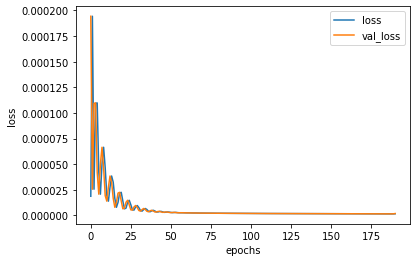

In [90]:
# Plot history (also known as a loss curve)
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

predict the vehicle for a ride by including the vehicle information in the input and target data and leaving a placeholder (e.g. zero) in place of the vehicle information at the time of prediction

In [102]:
pred = model.predict([input[0], target[0]])

ValueError: ignored

In [ ]:
pred[0][0]

In [ ]:
target[0][0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_vectors_cosine_similarity(vector1, vector2):
    similarity = cosine_similarity([vector1], [vector2])[0][0]
    fig, ax = plt.subplots()
    ax.plot(vector1, label='Prediction')
    ax.plot(vector2, label='Target')
    ax.set_title('Cosine Similarity: {:.2f}'.format(similarity))
    ax.legend()
    plt.show()
plot_vectors_cosine_similarity(pred[0][0], target[0][0])

In [ ]:
def comparison_ordering(master, slave):
  """ Compares and orders the inputs by the preds """

  max_finder = pd.DataFrame(columns=["pred", "original_input", "cos_similarity"])
  ordered_rides = pd.DataFrame(columns = [
    'space_type',
    'billable_distance',
    'run_name',
    'rider.mediroutes_rider_id',
    'pickup.event_location.zip',
    'pickup.event_location.longitude',
    'pickup.event_location.latitude',
    'dropoff.event_location.zip',
    'dropoff.event_location.longitude',
    'dropoff.event_location.latitude',
    'pickup_hour',
    'pickup_minute',
    'prediction_highest_scores',
    'similarity_high_score'
  ])

  for i in master: # order the j vector by the master
    for j in slave:
      cos_similarity = cosine_similarity(i.reshape(1, -1), j.reshape(1, -1))

      # Add mapping to max finder
      row = {"pred": i, "original_input": j, "cos_similarity": cos_similarity}
      max_finder = max_finder.append(row, ignore_index=True)

    # Find the winner
    max_row_index = np.argmax(max_finder['cos_similarity'])
    most_similar = max_finder.loc[max_row_index]

    # Get prediction info - just a check to see if max_row_index is returning the best value every time.
    max_finder.sort_values(by='cos_similarity', ascending=False, inplace=True)
    scores = max_finder['cos_similarity'][:3]
    scores = [round(x[0][0],4) for x in scores]

    highest_score = np.amax(scores)
    prediction_info = [np.sort(scores), highest_score]

    # Add most similar ride to ordered rides in order of predictions against the target
    row = {'space_type' : most_similar[1][0],
    'billable_distance' : most_similar[1][1],
    'run_name' : most_similar[1][2],
    'rider.mediroutes_rider_id' : most_similar[1][3],
    'pickup.event_location.zip' : most_similar[1][4],
    'pickup.event_location.longitude' : most_similar[1][5],
    'pickup.event_location.latitude' : most_similar[1][6],
    'dropoff.event_location.zip' : most_similar[1][7],
    'dropoff.event_location.longitude' : most_similar[1][8],
    'dropoff.event_location.latitude' : most_similar[1][9],
    'pickup_hour' : most_similar[1][10],
    'pickup_minute' : most_similar[1][11],
    'prediction_highest_scores' : prediction_info[:-1],
    'similarity_high_score' : prediction_info[1]
    }
    
    ordered_rides = ordered_rides.append(row, ignore_index=True)

    # Reset max finder so it starts empty for the next iteration
    max_finder = pd.DataFrame(columns=["pred", "original_input", "cos_similarity"])
    scores = []
  return ordered_rides

ordered_rides = comparison_ordering(pred[0], input[0])

In [ ]:
ordered_rides.iloc[:10,:]

In [ ]:
target_df.iloc[:10,:]

In [ ]:
target_df = pd.DataFrame(target[0], columns=[
  'space_type',
  'billable_distance',
  'run_name',
  'rider.mediroutes_rider_id',
  'pickup.event_location.zip',
  'pickup.event_location.longitude',
  'pickup.event_location.latitude',
  'dropoff.event_location.zip',
  'dropoff.event_location.longitude',
  'dropoff.event_location.latitude',
  'pickup_hour',
  'pickup_minute'
])

In [ ]:
target_df.head(10)